In [2]:
# %% [code]
# HOME CREDIT DEFAULT RISK COMPETITION
# Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
# You can use LightGBM with KFold or Stratified KFold.

# Update 16/06/2018:
# - Added Payment Rate feature
# - Removed index from features
# - Use standard KFold CV (not stratified)

import numpy as np
import pandas as pd
import gc
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import mlflow
import mlflow.sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Feature Engineering

In [67]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv
def application_train(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv(r"C:\Users\mauge\Openclassrooms\Projet 7 - Implémenter un modèle de scoring\Projet+Mise+en+prod+-+home-credit-default-risk\application_train.csv", nrows= num_rows)
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    gc.collect()
    return df

In [4]:
# Appeler la fonction pour traiter les données d'entraînement
df_application = application_train()

In [5]:
df_application.head(1)

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_

In [6]:
df_application.shape

(307507, 247)

In [7]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv(r"C:\Users\mauge\Openclassrooms\Projet 7 - Implémenter un modèle de scoring\Projet+Mise+en+prod+-+home-credit-default-risk\bureau.csv", nrows = num_rows)
    bb = pd.read_csv(r"C:\Users\mauge\Openclassrooms\Projet 7 - Implémenter un modèle de scoring\Projet+Mise+en+prod+-+home-credit-default-risk\bureau_balance.csv", nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [8]:
df_bureau_and_balance = bureau_and_balance()

In [9]:
df_bureau_and_balance.head(1)

,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_MAX,BURO_AMT_CREDIT_SUM_MEAN,BURO_AMT_CREDIT_SUM_SUM,BURO_AMT_CREDIT_SUM_DEBT_MAX,BURO_AMT_CREDIT_SUM_DEBT_MEAN,BURO_AMT_CREDIT_SUM_DEBT_SUM,BURO_AMT_CREDIT_SUM_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_LIMIT_MEAN,BURO_AMT_CREDIT_SUM_LIMIT_SUM,BURO_AMT_ANNUITY_MAX,BURO_AMT_ANNUITY_MEAN,BURO_CNT_CREDIT_PROLONG_SUM,BURO_MONTHS_BALANCE_MIN_MIN,BURO_MONTHS_BALANCE_MAX_MAX,BURO_MONTHS_BALANCE_SIZE_MEAN,BURO_MONTHS_BALANCE_SIZE_SUM,BURO_CREDIT_ACTIVE_Active_MEAN,BURO_CREDIT_ACTIVE_Bad debt_MEAN,BURO_CREDIT_ACTIVE_Closed_MEAN,BURO_CREDIT_ACTIVE_Sold_MEAN,BURO_CREDIT_ACTIVE_nan_MEAN,BURO_CREDIT_CURRENCY_currency 1_MEAN,BURO_CREDIT_CURRENCY_currency 2_MEAN,BURO_CREDIT_CURRENCY_currency 3_MEAN,BURO_CREDIT_CURRENCY_currency 4_MEAN,BURO_CREDIT_CURRENCY_nan_MEAN,BURO_CREDIT_TYPE_Another type of loan_MEAN,BURO_CREDIT_TYPE_Car loan_MEAN,BURO_CREDIT_TYPE_Cash loan (non-earmarked)_MEAN,BURO_CREDIT_TYPE_Consumer credit_MEAN,BURO_CREDIT_TYPE_Credit card_MEAN,BURO_CREDIT_TYPE_Interbank credit_MEAN,BURO_CREDIT_TYPE_Loan for business development_MEAN,BURO_CREDIT_TYPE_Loan for purchase of shares (margin lending)_MEAN,BURO_CREDIT_TYPE_Loan for the purchase of equipment_MEAN,BURO_CREDIT_TYPE_Loan for working capital replenishment_MEAN,BURO_CREDIT_TYPE_Microloan_MEAN,BURO_CREDIT_TYPE_Mobile operator loan_MEAN,BURO_CREDIT_TYPE_Mortgage_MEAN,BURO_CREDIT_TYPE_Real estate loan_MEAN,BURO_CREDIT_TYPE_Unknown type of loan_MEAN,BURO_CREDIT_TYPE_nan_MEAN,BURO_STATUS_0_MEAN_MEAN,BURO_STATUS_1_MEAN_MEAN,BURO_STATUS_2_MEAN_MEAN,BURO_STATUS_3_MEAN_MEAN,BURO_STATUS_4_MEAN_MEAN,BURO_STATUS_5_MEAN_MEAN,BURO_STATUS_C_MEAN_MEAN,BURO_STATUS_X_MEAN_MEAN,BURO_STATUS_nan_MEAN_MEAN,ACTIVE_DAYS_CREDIT_MIN,ACTIVE_DAYS_CREDIT_MAX,ACTIVE_DAYS_CREDIT_MEAN,ACTIVE_DAYS_CREDIT_VAR,ACTIVE_DAYS_CREDIT_ENDDATE_MIN,ACTIVE_DAYS_CREDIT_ENDDATE_MAX,ACTIVE_DAYS_CREDIT_ENDDATE_MEAN,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,ACTIVE_CREDIT_DAY_OVERDUE_MAX,ACTIVE_CREDIT_DAY_OVERDUE_MEAN,ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN,ACTIVE_AMT_CREDIT_SUM_MAX,ACTIVE_AMT_CREDIT_SUM_MEAN,ACTIVE_AMT_CREDIT_SUM_SUM,ACTIVE_AMT_CREDIT_SUM_DEBT_MAX,ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN,ACTIVE_AMT_CREDIT_SUM_DEBT_SUM,ACTIVE_AMT_CREDIT_SUM_OVERDUE_MEAN,ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN,ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM,ACTIVE_AMT_ANNUITY_MAX,ACTIVE_AMT_ANNUITY_MEAN,ACTIVE_CNT_CREDIT_PROLONG_SUM,ACTIVE_MONTHS_BALANCE_MIN_MIN,ACTIVE_MONTHS_BALANCE_MAX_MAX,ACTIVE_MONTHS_BALANCE_SIZE_MEAN,ACTIVE_MONTHS_BALANCE_SIZE_SUM,CLOSED_DAYS_CREDIT_MIN,CLOSED_DAYS_CREDIT_MAX,CLOSED_DAYS_CREDIT_MEAN,CLOSED_DAYS_CREDIT_VAR,CLOSED_DAYS_CREDIT_ENDDATE_MIN,CLOSED_DAYS_CREDIT_ENDDATE_MAX,CLOSED_DAYS_CREDIT_ENDDATE_MEAN,CLOSED_DAYS_CREDIT_UPDATE_MEAN,CLOSED_CREDIT_DAY_OVERDUE_MAX,CLOSED_CREDIT_DAY_OVERDUE_MEAN,CLOSED_AMT_CREDIT_MAX_OVERDUE_MEAN,CLOSED_AMT_CREDIT_SUM_MAX,CLOSED_AMT_CREDIT_SUM_MEAN,CLOSED_AMT_CREDIT_SUM_SUM,CLOSED_AMT_CREDIT_SUM_DEBT_MAX,CLOSED_AMT_CREDIT_SUM_DEBT_MEAN,CLOSED_AMT_CREDIT_SUM_DEBT_SUM,CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_SUM,CLOSED_AMT_ANNUITY_MAX,CLOSED_AMT_ANNUITY_MEAN,CLOSED_CNT_CREDIT_PROLONG_SUM,CLOSED_MONTHS_BALANCE_MIN_MIN,CLOSED_MONTHS_BALANCE_MAX_MAX,CLOSED_MONTHS_BALANCE_SIZE_MEAN,CLOSED_MONTHS_BALANCE_SIZE_SUM
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,-1572,-49,-735.0,240043.666667,-1329.0,1778.0,82.428571,-93.142857,0,0.0,NaN,378000.0,207623.571429,1453365.0,373239.0,85240.928571,596686.5,0.0,0.0,0.0,10822.5,3545.357143,0,-51.0,0.0,24.571429,172.0,0.428571,0.0,0.571429,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.336651,0.

In [10]:
df_bureau_and_balance.shape

(305811, 116)

In [11]:
bureau = pd.read_csv(r"C:\Users\mauge\Openclassrooms\Projet 7 - Implémenter un modèle de scoring\Projet+Mise+en+prod+-+home-credit-default-risk\bureau.csv")
bureau.shape

(1716428, 17)

In [12]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv(r"C:\Users\mauge\Openclassrooms\Projet 7 - Implémenter un modèle de scoring\Projet+Mise+en+prod+-+home-credit-default-risk\previous_application.csv", nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

In [13]:
df_previous_applications = previous_applications()
df_previous_applications.head(1)

KeyboardInterrupt: 

In [ ]:
df_previous_applications.shape

In [ ]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv(r"C:\Users\mauge\Openclassrooms\Projet 7 - Implémenter un modèle de scoring\Projet+Mise+en+prod+-+home-credit-default-risk\POS_CASH_balance.csv", nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [ ]:
df_pos_cash = pos_cash()
df_pos_cash.head(1)

In [ ]:
df_pos_cash.shape

In [68]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv(r"C:\Users\mauge\Openclassrooms\Projet 7 - Implémenter un modèle de scoring\Projet+Mise+en+prod+-+home-credit-default-risk\installments_payments.csv", nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [69]:
df_installments_payments = installments_payments()
df_installments_payments.head(1)

,INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE,INSTAL_DPD_MAX,INSTAL_DPD_MEAN,INSTAL_DPD_SUM,INSTAL_DBD_MAX,INSTAL_DBD_MEAN,INSTAL_DBD_SUM,INSTAL_PAYMENT_PERC_MAX,INSTAL_PAYMENT_PERC_MEAN,INSTAL_PAYMENT_PERC_SUM,INSTAL_PAYMENT_PERC_VAR,INSTAL_PAYMENT_DIFF_MAX,INSTAL_PAYMENT_DIFF_MEAN,INSTAL_PAYMENT_DIFF_SUM,INSTAL_PAYMENT_DIFF_VAR,INSTAL_AMT_INSTALMENT_MAX,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,2,11.0,1.571429,11.0,36.0,8.857143,62.0,1.0,1.0,7.0,0.0,0.0,0.0,0.0,0.0,17397.9,5885.132143,41195.925,3951.0,17397.9,5885.132143,41195.925,-1628.0,-2195.0,-15365.0,7


In [ ]:
df_installments_payments.shape

In [ ]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv(r"C:\Users\mauge\Openclassrooms\Projet 7 - Implémenter un modèle de scoring\Projet+Mise+en+prod+-+home-credit-default-risk\credit_card_balance.csv", nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [ ]:
df_credit_card_balance = credit_card_balance()
df_credit_card_balance.head(1)

In [ ]:
df_credit_card_balance.info()

In [ ]:
df_credit_card_balance.shape

In [ ]:
def final_df():
    
    # Prétraitement des fichiers application_train et application_test
    df = application_train()
    
    # Traitement du fichier bureau.csv et bureau_balance.csv
    bureau = bureau_and_balance()
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    
    # Traitement du fichier previous_applications.csv
    prev = previous_applications()
    df = df.join(prev, how='left', on='SK_ID_CURR')
    
    # Traitement du fichier POS_CASH_balance.csv
    pos = pos_cash()
    df = df.join(pos, how='left', on='SK_ID_CURR')
    
    # Traitement du fichier installments_payments.csv
    ins = installments_payments()
    df = df.join(ins, how='left', on='SK_ID_CURR')
    
    # Traitement du fichier credit_card_balance.csv
    cc = credit_card_balance()
    df = df.join(cc, how='left', on='SK_ID_CURR')
    
    return df


In [ ]:
df_final = final_df()
df_final.head(1)

In [ ]:
df_final.shape

In [45]:
df_final.to_csv('df_final1.csv', index=False, sep=';', encoding='utf-8')

# Pré-traitement

In [4]:
df_final = pd.read_csv(r"C:\Users\mauge\Openclassrooms\Projet 7 - Hors repo\df_final.csv", sep=';')

In [5]:
df_final.shape

(307507, 797)

In [6]:
df_final.columns.tolist()

['SK_ID_CURR',
 'TARGET',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 

In [7]:
df_final.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_

In [8]:
df_reduced = df_final.loc[:, df_final.isna().mean() <= 0.5]

In [9]:
df_reduced.shape

(307507, 561)

In [10]:
df_reduced['TARGET'].isna().mean()

0.0

In [11]:
proportion_1 = (df_reduced['TARGET'] == 1).mean()
print(proportion_1)

0.08072986956394489


In [12]:
max_values = df_reduced.max()

# Trier les valeurs maximales par ordre décroissant
max_values_sorted = max_values.sort_values(ascending=False)

# Afficher les valeurs triées
print(max_values_sorted.tolist())

[inf, inf, inf, inf, inf, 445993643959.2246, 1017957917.385, 1017597917.385, 967504461.5627528, 396000000.0, 396000000.0, 334739700.0, 334498331.20500004, 334498331.20500004, 198072344.25, 198072344.25, 170100000.0, 170100000.0, 170100000.0, 117000000.0, 115987185.0, 90034675.5, 83624582.80125001, 43650000.0, 39000000.0, 25537053.78, 23274726.93, 17866476.0, 10564983.0, 8129328.210000001, 8126600.490000001, 7279290.0, 5850000.0, 5850000.0, 5850000.0, 5850000.0, 4509688.5, 4509688.5, 4500000.0, 4500000.0, 4173160.5, 4050000.0, 4050000.0, 4050000.0, 4050000.0, 4050000.0, 4050000.0, 4050000.0, 4050000.0, 4050000.0, 4050000.0, 4050000.0, 4050000.0, 4050000.0, 4050000.0, 4032800.0, 3771487.845, 3771487.845, 3681063.0, 3060045.0, 3060045.0, 3037735.575, 2504589.66, 2504589.66, 2504589.66, 2424726.4050000003, 2250000.0, 2025000.0, 2025000.0, 2025000.0, 2025000.0, 1617403.5, 1125000.0, 617070.0, 456255, 418058.145, 393868.665, 300425.445, 300425.445, 300425.445, 300425.445, 258025.5, 146145.9,

In [13]:
# Obtenir les colonnes triées et leurs valeurs maximales
columns_sorted = max_values_sorted.index.tolist()
values_sorted = max_values_sorted.tolist()

# Associer les colonnes avec les valeurs maximales
columns_with_max_values = list(zip(columns_sorted, values_sorted))

# Afficher les colonnes et les valeurs triées
print(columns_with_max_values[:7])


[('PREV_APP_CREDIT_PERC_MEAN', inf), ('PREV_APP_CREDIT_PERC_MAX', inf), ('INSTAL_PAYMENT_PERC_MAX', inf), ('INSTAL_PAYMENT_PERC_MEAN', inf), ('INSTAL_PAYMENT_PERC_SUM', inf), ('INSTAL_PAYMENT_DIFF_VAR', 445993643959.2246), ('BURO_AMT_CREDIT_SUM_SUM', 1017957917.385)]


In [14]:
df_reduced['AMT_INCOME_TOTAL'].max()

117000000.0

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_distribution(df, column_name):
    """
    Affiche la distribution d'une colonne du DataFrame.
    :param df: DataFrame contenant les données
    :param column_name: Nom de la colonne à visualiser
    """
    plt.figure(figsize=(10, 6))
    
    # Visualiser la distribution avec un histogramme et une courbe de densité (kde)
    sns.histplot(df[column_name], kde=True, bins=30)
    
    plt.title(f'Distribution de la colonne {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Fréquence')
    plt.grid(True)
    plt.show()


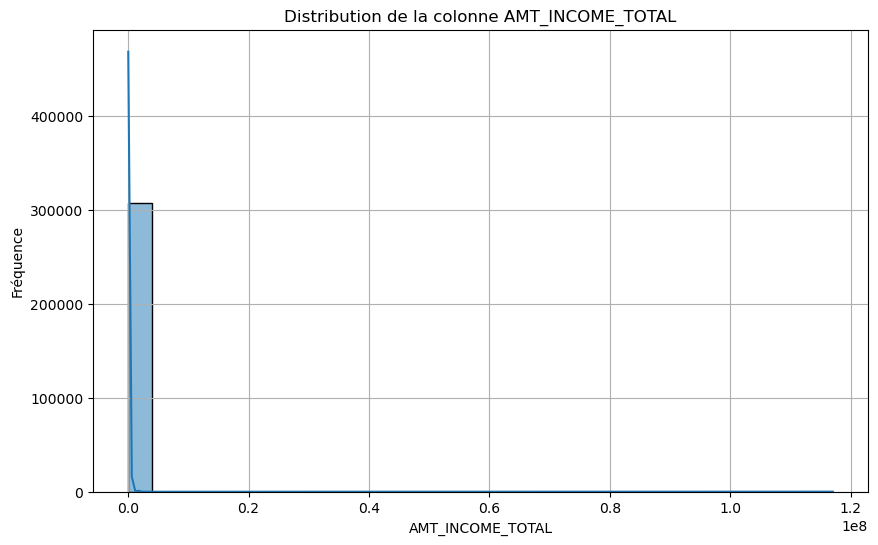

In [16]:

# Utilisation de la fonction
plot_distribution(df_reduced, 'AMT_INCOME_TOTAL')

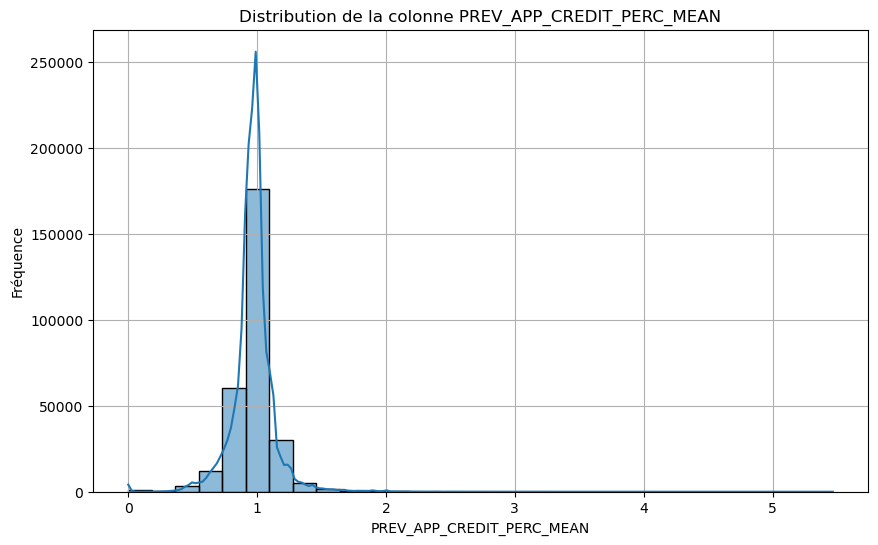

In [17]:
# Utilisation de la fonction
plot_distribution(df_reduced, 'PREV_APP_CREDIT_PERC_MEAN')

In [18]:
df_reduced['PREV_APP_CREDIT_PERC_MEAN'].max()

inf

In [19]:
def remove_outliers_iqr(df, column_name, threshold=10):
    """
    Supprime les outliers dans une colonne donnée en utilisant l'IQR.
    :param df: DataFrame contenant les données
    :param column_name: Nom de la colonne à nettoyer
    :param threshold: Facteur pour déterminer les outliers (par défaut 1.5)
    :return: DataFrame sans les outliers dans la colonne spécifiée
    """
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    # Définir les bornes pour détecter les outliers
    lower_bound = Q1 - (threshold * IQR)
    upper_bound = Q3 + (threshold * IQR)

        # Supprimer les lignes contenant des outliers
    df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    
    return df

In [20]:
# Appliquer la fonction sur une colonne spécifique
df_cleaned = remove_outliers_iqr(df_reduced, 'AMT_INCOME_TOTAL')

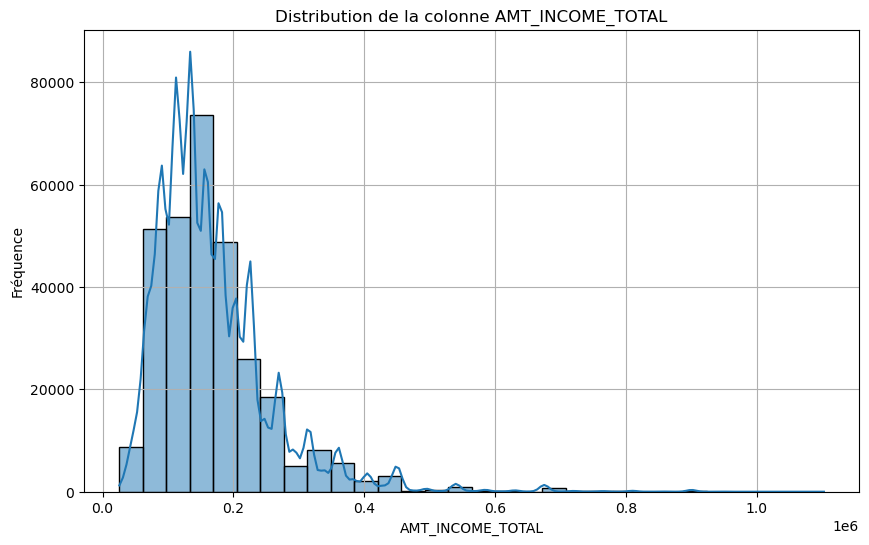

In [21]:
# Utilisation de la fonction
plot_distribution(df_cleaned, 'AMT_INCOME_TOTAL')

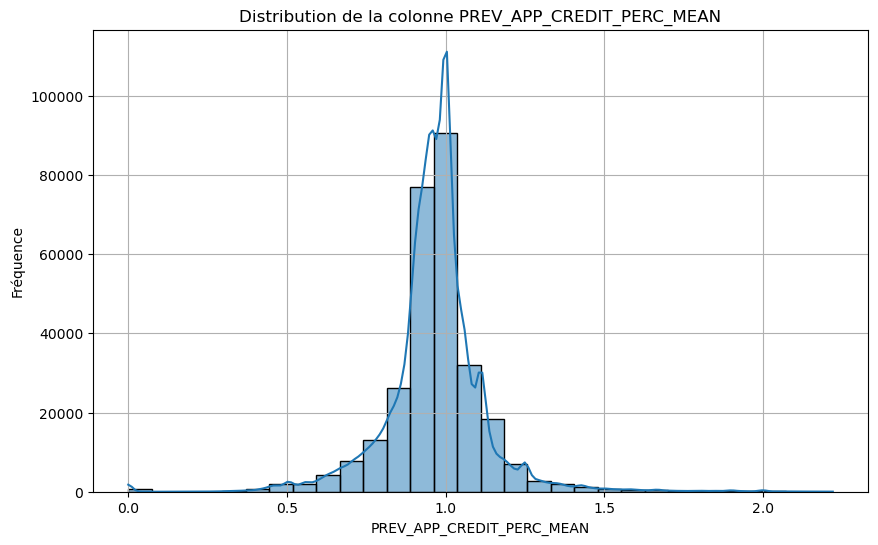

In [22]:
# Appliquer la fonction sur une colonne spécifique
df_cleaned = remove_outliers_iqr(df_cleaned, 'PREV_APP_CREDIT_PERC_MEAN')
# Utilisation de la fonction
plot_distribution(df_cleaned, 'PREV_APP_CREDIT_PERC_MEAN')

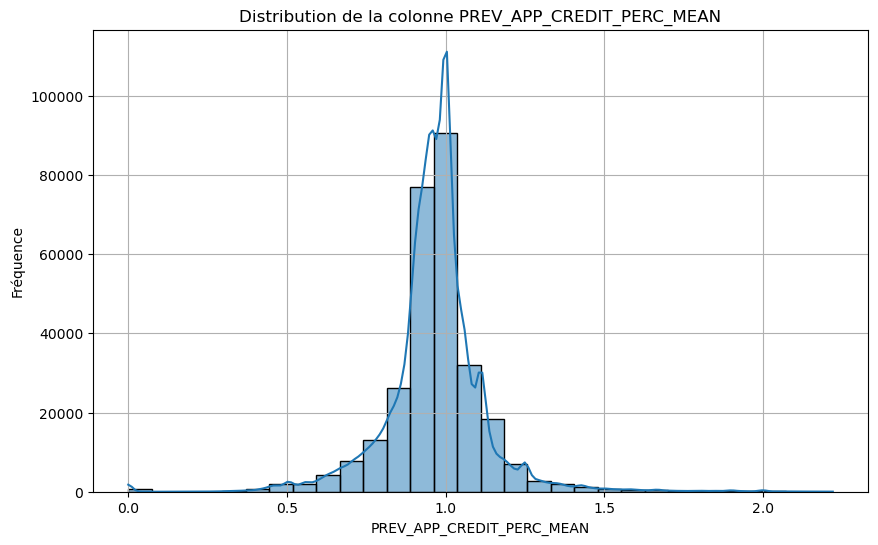

In [23]:
# Appliquer la fonction sur une colonne spécifique
df_cleaned = remove_outliers_iqr(df_cleaned, 'PREV_APP_CREDIT_PERC_MEAN')
# Utilisation de la fonction
plot_distribution(df_cleaned, 'PREV_APP_CREDIT_PERC_MEAN')

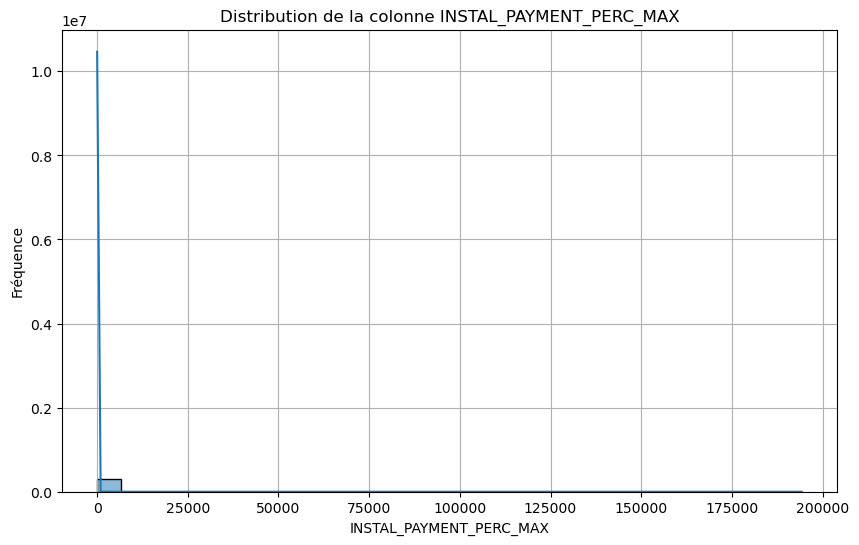

In [24]:
plot_distribution(df_reduced, 'INSTAL_PAYMENT_PERC_MAX')

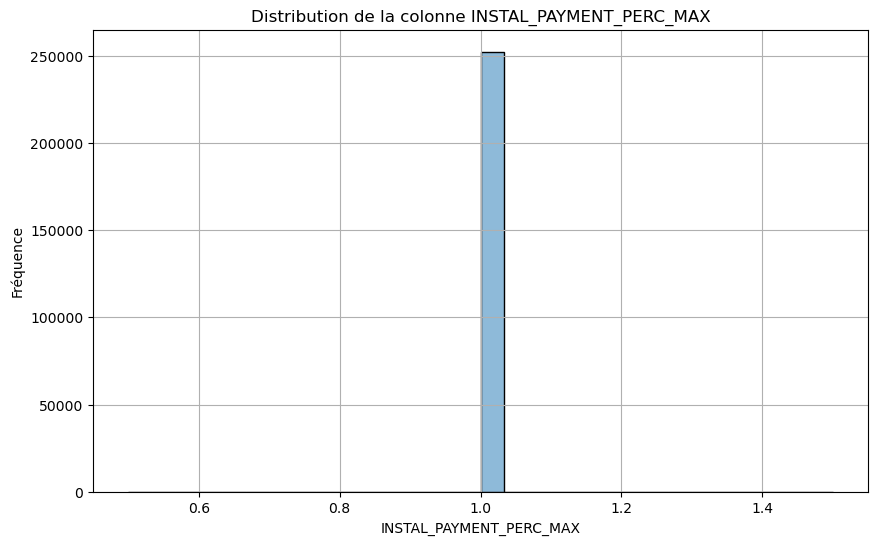

In [25]:
# Appliquer la fonction sur une colonne spécifique
df_cleaned = remove_outliers_iqr(df_cleaned, 'INSTAL_PAYMENT_PERC_MAX')
# Utilisation de la fonction
plot_distribution(df_cleaned, 'INSTAL_PAYMENT_PERC_MAX')

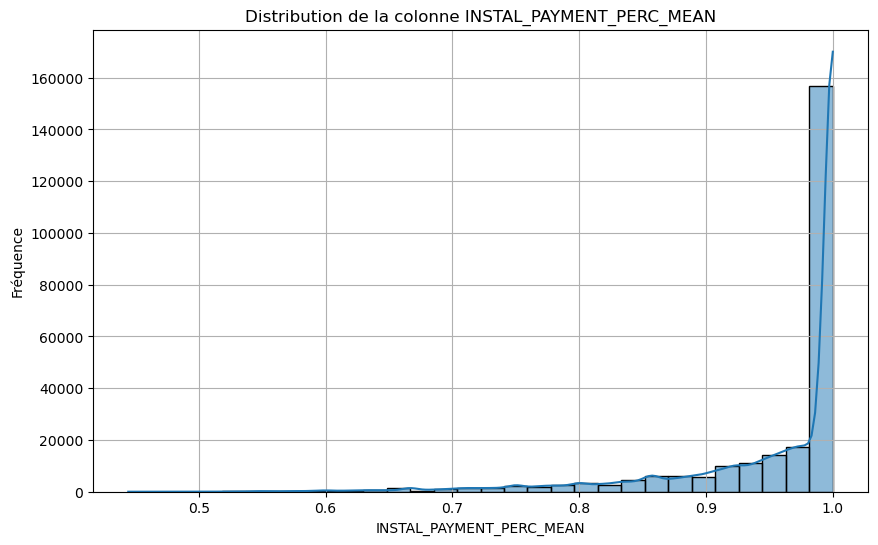

In [26]:
# Appliquer la fonction sur une colonne spécifique
df_cleaned = remove_outliers_iqr(df_cleaned, 'INSTAL_PAYMENT_PERC_MEAN')
# Utilisation de la fonction
plot_distribution(df_cleaned, 'INSTAL_PAYMENT_PERC_MEAN')

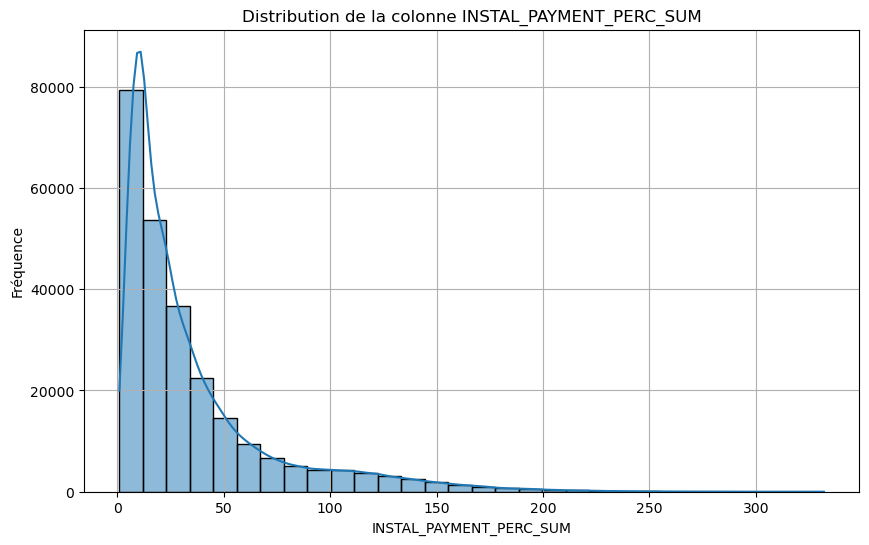

In [27]:
# Appliquer la fonction sur une colonne spécifique
df_cleaned = remove_outliers_iqr(df_cleaned, 'INSTAL_PAYMENT_PERC_SUM')
# Utilisation de la fonction
plot_distribution(df_cleaned, 'INSTAL_PAYMENT_PERC_SUM')

In [28]:
df_cleaned.shape

(252379, 561)

In [29]:
df_reduced.shape

(307507, 561)

In [30]:
# Identification des colonnes constantes
colonnes_constantes = [col for col in df_cleaned.columns if df_cleaned[col].nunique() == 1]
colonnes_constantes

['FLAG_MOBIL',
 'NAME_INCOME_TYPE_Businessman',
 'NAME_FAMILY_STATUS_Unknown',
 'BURO_CREDIT_ACTIVE_nan_MEAN',
 'BURO_CREDIT_CURRENCY_nan_MEAN',
 'BURO_CREDIT_TYPE_Mobile operator loan_MEAN',
 'BURO_CREDIT_TYPE_nan_MEAN',
 'PREV_NAME_CONTRACT_TYPE_nan_MEAN',
 'PREV_WEEKDAY_APPR_PROCESS_START_nan_MEAN',
 'PREV_FLAG_LAST_APPL_PER_CONTRACT_nan_MEAN',
 'PREV_NAME_CASH_LOAN_PURPOSE_nan_MEAN',
 'PREV_NAME_CONTRACT_STATUS_nan_MEAN',
 'PREV_NAME_PAYMENT_TYPE_nan_MEAN',
 'PREV_CODE_REJECT_REASON_nan_MEAN',
 'PREV_NAME_CLIENT_TYPE_nan_MEAN',
 'PREV_NAME_GOODS_CATEGORY_House Construction_MEAN',
 'PREV_NAME_GOODS_CATEGORY_nan_MEAN',
 'PREV_NAME_PORTFOLIO_nan_MEAN',
 'PREV_NAME_PRODUCT_TYPE_nan_MEAN',
 'PREV_CHANNEL_TYPE_nan_MEAN',
 'PREV_NAME_SELLER_INDUSTRY_nan_MEAN',
 'PREV_NAME_YIELD_GROUP_nan_MEAN',
 'POS_NAME_CONTRACT_STATUS_nan_MEAN',
 'INSTAL_PAYMENT_PERC_MAX']

In [31]:
df_cleaned = df_cleaned.drop(columns=colonnes_constantes)

In [32]:
df_cleaned.shape

(252379, 537)

## Sample dataset

In [33]:
from sklearn.model_selection import train_test_split

# Taille de l'échantillon souhaitée
sample_size = 0.3

# Création de l'échantillon avec stratification pour respecter les proportions dans la colonne 'TARGET'
df_sample, _ = train_test_split(df_cleaned, test_size=1-sample_size, stratify=df_cleaned['TARGET'], random_state=42)

In [34]:
df_sample.shape

(75713, 537)

In [35]:
proportion_2 = (df_sample['TARGET'] == 1).mean()
print(proportion_2)

0.08442407512580402


In [36]:
df_sample['TARGET'].unique()

array([0, 1], dtype=int64)

# Pré-traitement / Train Test split

In [76]:
df_model = df_sample.copy()

In [77]:
# Supposons que df_model soit votre DataFrame avec les données
X = df_model.drop(columns=['TARGET', 'SK_ID_CURR'])  # Features
y = df_model['TARGET']  # Target

# Étape 1 : Split en jeu d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Supposons que df_model soit votre DataFrame avec les données
X = df_model.drop(columns=['TARGET', 'SK_ID_CURR'])  # Features
y = df_model['TARGET']  # Target

# Étape 1 : Split en jeu d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Étape 2 : Créer le pipeline de pré-traitement
preprocessing_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Imputation des valeurs manquantes
    ('scaler', MinMaxScaler(feature_range=(0, 1)))  # Mise à l'échelle
])

# Étape 3 : Ajuster le pipeline uniquement sur le jeu d'entraînement
X_train = preprocessing_pipeline.fit_transform(X_train)

# Étape 4 : Appliquer les transformations sur le jeu de test
X_test = preprocessing_pipeline.transform(X_test)


In [38]:
mean_value_test = np.mean(y_test)
mean_value_test

0.08604635805322591

In [39]:
mean_value_train = np.mean(y_train)
mean_value_train

0.08401849100214628

In [45]:
import joblib
joblib.dump(preprocessing_pipeline, 'preprocessing_pipeline.pkl')

['preprocessing_pipeline.pkl']

## Dummy

In [40]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score

# Stratégie "stratified" (fournit des probabilités)
dummy_stratified = DummyClassifier(strategy="stratified")
dummy_stratified.fit(X_train, y_train)
y_proba_stratified = dummy_stratified.predict_proba(X_test)[:, 1]  # Probabilité de la classe positive (1)
y_pred_dummy = dummy_stratified.predict(X_test)

# Calcul du score AUC
auc_stratified = roc_auc_score(y_test, y_proba_stratified)
print(f"AUC (Stratified): {auc_stratified:.4f}")

# Calcul du recall pour DummyClassifier
recall_dummy = recall_score(y_test, y_pred_dummy)
print(f"Dummy Classifier (Most Frequent) Recall: {recall_dummy:.4f}")


AUC (Stratified): 0.5024
Dummy Classifier (Most Frequent) Recall: 0.0952


## Optimisation métier

In [41]:
from sklearn.metrics import make_scorer

def custom_cost_function(y_true, y_pred, fn_cost=1, fp_cost=1):
    """
    Fonction pour calculer le coût métier basé sur les FN et FP.
    :param y_true: Vraies étiquettes
    :param y_pred: Étiquettes prédites (binaires après application d'un seuil)
    :param fn_cost: Coût d'un faux négatif (par défaut 10 fois plus élevé)
    :param fp_cost: Coût d'un faux positif (par défaut 1)
    :return: Coût total
    """
    # Calcul des FN et FP
    FN = np.sum((y_true == 1) & (y_pred == 0))  # Faux négatifs
    FP = np.sum((y_true == 0) & (y_pred == 1))  # Faux positifs
    
    # Calcul du coût métier
    cost = FN * fn_cost + FP * fp_cost
    return cost


# Créer un scorer basé sur le coût métier (à minimiser)
cost_scorer = make_scorer(custom_cost_function, fn_cost=1, fp_cost=1, greater_is_better=False)


In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score

# Fonction pour trouver le meilleur seuil basé sur le coût métier
def find_optimal_threshold(y_true, y_pred_proba, fn_cost=100, fp_cost=1):
    thresholds = np.arange(0.0, 1.0, 0.01)  # Tester différents seuils de 0 à 1
    costs = []

    for threshold in thresholds:
        # Appliquer un seuil pour obtenir des prédictions binaires
        y_pred = (y_pred_proba >= threshold).astype(int)
        
        # Calculer le coût métier
        cost = custom_cost_function(y_true, y_pred, fn_cost=fn_cost, fp_cost=fp_cost)
        costs.append(cost)

    # Trouver le seuil qui minimise le coût
    optimal_idx = np.argmin(costs)
    optimal_threshold = thresholds[optimal_idx]
    
    # Plot du coût par rapport au seuil
    plt.plot(thresholds, costs)
    plt.xlabel('Seuil')
    plt.ylabel('Coût métier')
    plt.title('Optimisation du seuil en fonction du coût métier')
    plt.show()
    
    return optimal_threshold, costs[optimal_idx]


## Régression logistique

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Meilleurs paramètres: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}


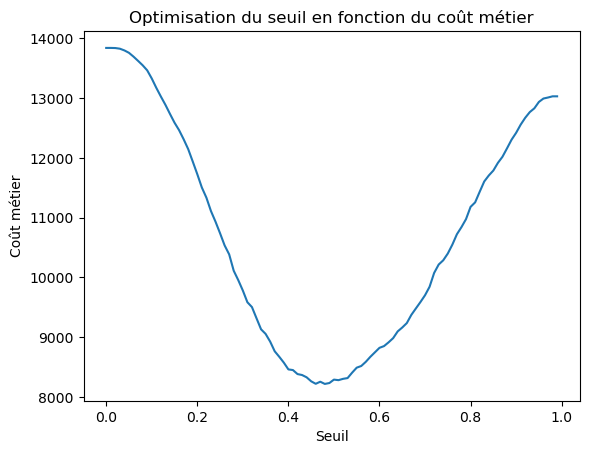

AUC sur l'ensemble de test : 0.7558
Recall sur l'ensemble de test : 0.7153
Accuracy pour la classe 1 sur l'ensemble de test : 0.6779
Custom cost sur l'ensemble de test : 8217.0000
Matrice de confusion sur l'ensemble de test :
[[9333 4507]
 [ 371  932]]
AUC sur l'ensemble d'entraînement : 0.7737
Recall sur l'ensemble d'entraînement : 0.7284
Accuracy pour la classe 1 sur l'ensemble d'entraînement : 0.6811
Custom cost sur l'ensemble d'entraînement : 31753.0000
Matrice de confusion sur l'ensemble d'entraînement :
[[37548 17933]
 [ 1382  3707]]


2024/11/24 14:01:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/24 14:01:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run Logistic Regression avec 30% dataset at: http://127.0.0.1:5000/#/experiments/0/runs/f782c779feec47588f7728b13f636498.
2024/11/24 14:01:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0.


In [43]:
import mlflow
import mlflow.sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, confusion_matrix, make_scorer
import numpy as np

# Définir l'URL de suivi (ici, c'est ton serveur MLflow local)
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Créer un scorer basé sur la fonction de coût
cost_scorer = make_scorer(custom_cost_function, fn_cost=10, fp_cost=1, greater_is_better=False)

# Démarrer un run MLflow pour suivre une expérimentation
with mlflow.start_run(run_name="Logistic Regression avec 30% dataset"):
    # Espace de recherche des hyperparamètres
    param_grid = {
        'C': [0.1],  # Différents niveaux de régularisation
        'penalty': ['l2'],  # Types de régularisation
        'solver': ['lbfgs'],  # Le solver 'lbfgs' supporte uniquement l2
        'class_weight': ['balanced']  # Prendre en compte le déséquilibre de classe
    }
    
    # Créer le modèle de régression logistique
    log_reg = LogisticRegression(max_iter=1000)
    
    # Définir la validation croisée avec GridSearchCV en utilisant le scorer personnalisé
    grid_search = GridSearchCV(
        estimator=log_reg,
        param_grid=param_grid,
        scoring=cost_scorer,  # Utiliser la fonction de coût personnalisée comme métrique
        cv=5,  # Validation croisée 5-fold
        verbose=1,  # Affiche les détails de la recherche
        n_jobs=-1  # Utilise tous les cœurs disponibles pour accélérer le calcul
    )
    
    # Entraîner GridSearchCV
    grid_search.fit(X_train, y_train)

    # Afficher les meilleurs paramètres trouvés
    best_params = grid_search.best_params_
    print(f"Meilleurs paramètres: {best_params}")

    # Enregistrer les meilleurs hyperparamètres dans MLflow
    mlflow.log_params(best_params)

    # Utiliser les meilleurs paramètres pour prédire sur les données de test
    best_model = grid_search.best_estimator_
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    
    # Trouver le seuil optimal
    optimal_threshold, min_cost = find_optimal_threshold(y_test, y_pred_proba, fn_cost=10, fp_cost=1)   
   
    # Prédictions avec le seuil optimisé
    y_pred_optimized = (y_pred_proba >= optimal_threshold).astype(int)

    # Obtenir les prédictions optimisées sur l'ensemble d'entraînement
    y_pred_train_proba = best_model.predict_proba(X_train)[:, 1]  # Probabilités pour la classe positive
    # Appliquer le seuil optimal pour générer les prédictions binaires sur l'ensemble d'entraînement
    y_pred_train_optimized = (y_pred_train_proba >= optimal_threshold).astype(int)
    
    # Calcul des métriques pour X_test
    logreg_recall_test = recall_score(y_test, y_pred_optimized)
    logreg_accuracy_test = accuracy_score(y_test, y_pred_optimized)
    auc_score_test = roc_auc_score(y_test, y_pred_proba)
    cost_with_optimal_threshold_test = custom_cost_function(y_test, y_pred_optimized, fn_cost=10, fp_cost=1)
    conf_matrix_test = confusion_matrix(y_test, y_pred_optimized)
    
    # Calcul des métriques pour X_train
    logreg_recall_train = recall_score(y_train, y_pred_train_optimized)
    logreg_accuracy_train = accuracy_score(y_train, y_pred_train_optimized)
    auc_score_train = roc_auc_score(y_train, y_pred_train_proba)
    cost_with_optimal_threshold_train = custom_cost_function(y_train, y_pred_train_optimized, fn_cost=10, fp_cost=1)
    conf_matrix_train = confusion_matrix(y_train, y_pred_train_optimized)
    
    # Affichage des résultats pour X_test
    print(f"AUC sur l'ensemble de test : {auc_score_test:.4f}")
    print(f"Recall sur l'ensemble de test : {logreg_recall_test:.4f}")
    print(f"Accuracy pour la classe 1 sur l'ensemble de test : {logreg_accuracy_test:.4f}")
    print(f"Custom cost sur l'ensemble de test : {cost_with_optimal_threshold_test:.4f}")
    print("Matrice de confusion sur l'ensemble de test :")
    print(conf_matrix_test)
    
    # Affichage des résultats pour X_train
    print(f"AUC sur l'ensemble d'entraînement : {auc_score_train:.4f}")
    print(f"Recall sur l'ensemble d'entraînement : {logreg_recall_train:.4f}")
    print(f"Accuracy pour la classe 1 sur l'ensemble d'entraînement : {logreg_accuracy_train:.4f}")
    print(f"Custom cost sur l'ensemble d'entraînement : {cost_with_optimal_threshold_train:.4f}")
    print("Matrice de confusion sur l'ensemble d'entraînement :")
    print(conf_matrix_train)
    
    # Enregistrer les métriques dans MLflow pour le jeu de test
    mlflow.log_metric("auc_test", auc_score_test)
    mlflow.log_metric("recall_test", logreg_recall_test)
    mlflow.log_metric("accuracy_class1_test", logreg_accuracy_test)
    mlflow.log_metric("custom_cost_test", cost_with_optimal_threshold_test)
    
    # Enregistrer les métriques dans MLflow pour le jeu d'entraînement
    mlflow.log_metric("auc_train", auc_score_train)
    mlflow.log_metric("recall_train", logreg_recall_train)
    mlflow.log_metric("accuracy_class1_train", logreg_accuracy_train)
    mlflow.log_metric("custom_cost_train", cost_with_optimal_threshold_train)

    # Enregistrer le modèle dans MLflow
    mlflow.sklearn.log_model(best_model, "best_model")


In [46]:
import joblib
joblib.dump(best_model, 'linear_regression_model.pkl')

['linear_regression_model.pkl']

# Reconnaissance des variables discrètes

In [106]:
column_names = df_model.drop(columns=['TARGET', 'SK_ID_CURR']).columns

In [107]:
X_train_df = pd.DataFrame(X_train, columns=column_names)
X_train_df.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_T

In [108]:
def detect_discrete_columns(df, max_unique_values=20):
    """
    Détecte les colonnes discrètes dans un DataFrame.
    :param df: DataFrame à analyser
    :param max_unique_values: Seuil maximum pour considérer une colonne comme discrète
    :return: Liste des indices des colonnes discrètes
    """
    discrete_columns = []

    for col in df.columns:
        # Comptage des valeurs uniques
        unique_values = df[col].nunique()
        # Vérifier si c'est une colonne discrète
        if unique_values <= max_unique_values:
            discrete_columns.append(col)
    
    return discrete_columns

column_names = df_model.drop(columns=['TARGET', 'SK_ID_CURR']).columns
X_train_df = pd.DataFrame(X_train, columns=column_names)

# Utilisation pour détecter les colonnes discrètes
discrete_cols = detect_discrete_columns(X_train_df)

# Pour obtenir les indices nécessaires à SMOTENC
discrete_indices = [X_train_df.columns.get_loc(col) for col in discrete_cols]
print("Indices des colonnes discrètes :", discrete_indices)
print ("Nombre de variables discrètes :", len(discrete_indices))


Indices des colonnes discrètes : [0, 1, 2, 3, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 38, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 224, 227, 232, 233, 236, 239, 241, 242, 243, 246, 247, 266, 276, 277, 284, 287, 322, 333, 334, 335, 336, 339, 342, 343, 344, 347, 351, 362, 370, 385, 386, 387, 394

# Régression logistique avec SMOTE

In [109]:
from imblearn.over_sampling import SMOTENC
# Instancier SMOTENC pour gérer les données encodées
smote_nc = SMOTENC(categorical_features=discrete_indices, random_state=10)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Meilleurs paramètres: {'model__C': 0.1, 'model__class_weight': 'balanced', 'model__penalty': 'l2', 'model__solver': 'saga'}


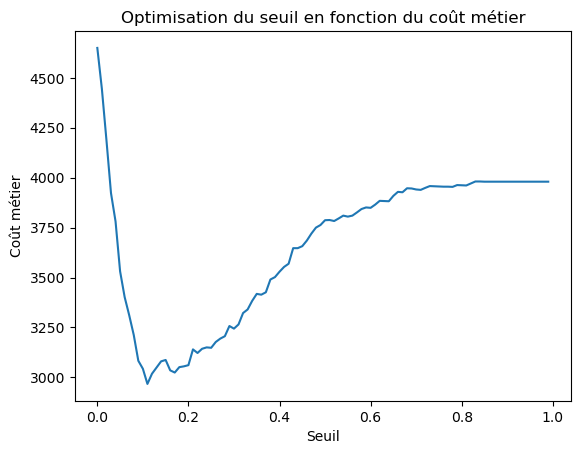

AUC sur l'ensemble de test : 0.6990
Recall sur l'ensemble de test : 0.6709
Accuracy pour la classe 1 sur l'ensemble de test : 0.6458
Custom cost sur l'ensemble de test : 2967.0000
Matrice de confusion sur l'ensemble de test :
[[2993 1657]
 [ 131  267]]
AUC sur l'ensemble d'entraînement : 0.7267
Recall sur l'ensemble d'entraînement : 0.6924
Accuracy pour la classe 1 sur l'ensemble d'entraînement : 0.6438
Custom cost sur l'ensemble d'entraînement : 11988.0000
Matrice de confusion sur l'ensemble d'entraînement :
[[11798  6658]
 [  533  1200]]


2024/11/24 00:02:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/24 00:02:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run Logistic Regression with SMOTE-NC Pipeline at: http://127.0.0.1:5000/#/experiments/0/runs/1dbaa412de5348ddb0188d99ffc33637.
2024/11/24 00:02:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0.


In [110]:
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, roc_auc_score, confusion_matrix
import mlflow
import mlflow.sklearn
import numpy as np

# Définir l'URL de suivi pour MLflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")


# Démarrer un run MLflow pour suivre une expérimentation
with mlflow.start_run(run_name="Logistic Regression with SMOTE-NC Pipeline"):
    # Instancier SMOTENC pour gérer les données encodées
    smote_nc = SMOTENC(categorical_features=discrete_indices, random_state=42)
    
    # Instancier le modèle
    log_reg = LogisticRegression(max_iter=1000)

    # Créer un pipeline avec SMOTENC et la régression logistique
    pipeline = Pipeline([
        ('smote', smote_nc),  # Étape de sur-échantillonnage
        ('model', log_reg)   # Modèle de régression logistique
    ])

    # Définir l'espace de recherche pour GridSearchCV
    param_grid = {
        'model__C': [0.1],  # Exemple de régularisation
        'model__penalty': ['l2'],      # Types de régularisation
        'model__solver': ['saga'],     # Solver 'saga' compatible avec l1 et l2
        'model__class_weight': ['balanced']  # Gérer le déséquilibre de classe
    }
    
    # Définir la validation croisée avec GridSearchCV
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring=cost_scorer,  # Utiliser votre fonction de coût personnalisée
        cv=5,  # Validation croisée 5-fold
        verbose=1,  # Afficher les informations détaillées
        n_jobs=-1   # Utiliser tous les cœurs disponibles
    )
    
    # Entraîner GridSearchCV (les données synthétiques ne sont générées que pour les données d'entraînement dans chaque pli)
    grid_search.fit(X_train, y_train)

    # Afficher les meilleurs paramètres trouvés
    best_params = grid_search.best_params_
    print(f"Meilleurs paramètres: {best_params}")
    mlflow.log_params(best_params)

    # Utiliser le meilleur modèle pour faire des prédictions sur le jeu de test
    best_model = grid_search.best_estimator_
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]

    # Trouver le seuil optimal basé sur le coût métier
    optimal_threshold, min_cost = find_optimal_threshold(y_test, y_pred_proba, fn_cost=10, fp_cost=1)

    # Appliquer le seuil optimal pour obtenir des prédictions binaires
    y_pred_optimized = (y_pred_proba >= optimal_threshold).astype(int)

    # Obtenir les prédictions optimisées sur l'ensemble d'entraînement
    y_pred_train_proba = best_model.predict_proba(X_train)[:, 1]  # Probabilités pour la classe positive
    # Appliquer le seuil optimal pour générer les prédictions binaires sur l'ensemble d'entraînement
    y_pred_train_optimized = (y_pred_train_proba >= optimal_threshold).astype(int)
    
    # Calcul des métriques pour X_test
    logreg_recall_test = recall_score(y_test, y_pred_optimized)
    logreg_accuracy_test = accuracy_score(y_test, y_pred_optimized)
    auc_score_test = roc_auc_score(y_test, y_pred_proba)
    cost_with_optimal_threshold_test = custom_cost_function(y_test, y_pred_optimized, fn_cost=10, fp_cost=1)
    conf_matrix_test = confusion_matrix(y_test, y_pred_optimized)
    
    # Calcul des métriques pour X_train
    logreg_recall_train = recall_score(y_train, y_pred_train_optimized)
    logreg_accuracy_train = accuracy_score(y_train, y_pred_train_optimized)
    auc_score_train = roc_auc_score(y_train, y_pred_train_proba)
    cost_with_optimal_threshold_train = custom_cost_function(y_train, y_pred_train_optimized, fn_cost=10, fp_cost=1)
    conf_matrix_train = confusion_matrix(y_train, y_pred_train_optimized)
    
    # Affichage des résultats pour X_test
    print(f"AUC sur l'ensemble de test : {auc_score_test:.4f}")
    print(f"Recall sur l'ensemble de test : {logreg_recall_test:.4f}")
    print(f"Accuracy pour la classe 1 sur l'ensemble de test : {logreg_accuracy_test:.4f}")
    print(f"Custom cost sur l'ensemble de test : {cost_with_optimal_threshold_test:.4f}")
    print("Matrice de confusion sur l'ensemble de test :")
    print(conf_matrix_test)
    
    # Affichage des résultats pour X_train
    print(f"AUC sur l'ensemble d'entraînement : {auc_score_train:.4f}")
    print(f"Recall sur l'ensemble d'entraînement : {logreg_recall_train:.4f}")
    print(f"Accuracy pour la classe 1 sur l'ensemble d'entraînement : {logreg_accuracy_train:.4f}")
    print(f"Custom cost sur l'ensemble d'entraînement : {cost_with_optimal_threshold_train:.4f}")
    print("Matrice de confusion sur l'ensemble d'entraînement :")
    print(conf_matrix_train)
    
    # Enregistrer les métriques dans MLflow pour le jeu de test
    mlflow.log_metric("auc_test", auc_score_test)
    mlflow.log_metric("recall_test", logreg_recall_test)
    mlflow.log_metric("accuracy_class1_test", logreg_accuracy_test)
    mlflow.log_metric("custom_cost_test", cost_with_optimal_threshold_test)
    
    # Enregistrer les métriques dans MLflow pour le jeu d'entraînement
    mlflow.log_metric("auc_train", auc_score_train)
    mlflow.log_metric("recall_train", logreg_recall_train)
    mlflow.log_metric("accuracy_class1_train", logreg_accuracy_train)
    mlflow.log_metric("custom_cost_train", cost_with_optimal_threshold_train)
    mlflow.sklearn.log_model(best_model, "best_model")

# Réduction de dimension PCA/Régression Logistique/Sans SMOTE

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Meilleurs paramètres: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}


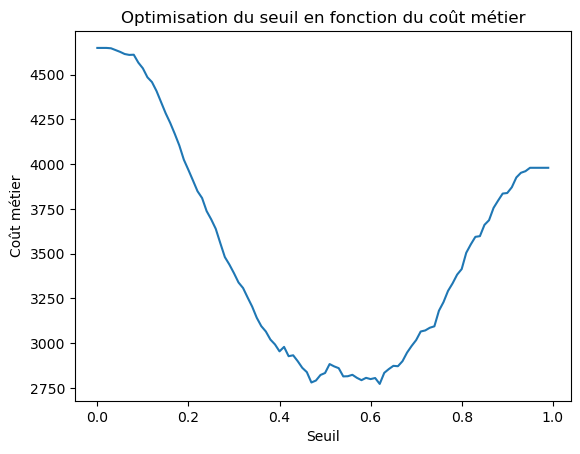

AUC sur l'ensemble de test : 0.7367
Recall sur l'ensemble de test : 0.4950
Accuracy pour la classe 1 sur l'ensemble de test : 0.8092
Custom cost sur l'ensemble de test : 2772.0000
Matrice de confusion sur l'ensemble de test :
[[3888  762]
 [ 201  197]]
AUC sur l'ensemble d'entraînement : 0.7612
Recall sur l'ensemble d'entraînement : 0.4870
Accuracy pour la classe 1 sur l'ensemble d'entraînement : 0.8115
Custom cost sur l'ensemble d'entraînement : 11807.0000
Matrice de confusion sur l'ensemble d'entraînement :
[[15539  2917]
 [  889   844]]


2024/11/24 00:03:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/24 00:03:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run Logistic Regression avec PCA/sans SMOTE at: http://127.0.0.1:5000/#/experiments/0/runs/5563e7502239424a994b7f84bd0f1d98.
2024/11/24 00:03:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0.


In [111]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, confusion_matrix, make_scorer

# Application de PCA sur X_train pour capturer 95% de la variance
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
# Définir l'URL de suivi (ici, c'est ton serveur MLflow local)
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Créer un scorer basé sur la fonction de coût
cost_scorer = make_scorer(custom_cost_function, fn_cost=10, fp_cost=1, greater_is_better=False)

# Démarrer un run MLflow pour suivre une expérimentation
with mlflow.start_run(run_name="Logistic Regression avec PCA/sans SMOTE"):
    # Espace de recherche des hyperparamètres
    param_grid = {
        'C': [0.1],  # Différents niveaux de régularisation
        'penalty': ['l2'],  # Types de régularisation
        'solver': ['lbfgs'],  # Le solver 'lbfgs' supporte uniquement l2
        'class_weight': ['balanced']  # Prendre en compte le déséquilibre de classe
    }
    
    # Créer le modèle de régression logistique
    log_reg = LogisticRegression(max_iter=1000)
    
    # Définir la validation croisée avec GridSearchCV en utilisant le scorer personnalisé
    grid_search = GridSearchCV(
        estimator=log_reg,
        param_grid=param_grid,
        scoring=cost_scorer,  # Utiliser la fonction de coût personnalisée comme métrique
        cv=5,  # Validation croisée 5-fold
        verbose=1,  # Affiche les détails de la recherche
        n_jobs=-1  # Utilise tous les cœurs disponibles pour accélérer le calcul
    )
    
    # Entraîner GridSearchCV
    grid_search.fit(X_train_pca, y_train)

    # Afficher les meilleurs paramètres trouvés
    best_params = grid_search.best_params_
    print(f"Meilleurs paramètres: {best_params}")

    # Enregistrer les meilleurs hyperparamètres dans MLflow
    mlflow.log_params(best_params)

    # Utiliser les meilleurs paramètres pour prédire sur les données de test
    best_model = grid_search.best_estimator_
    y_pred_proba = best_model.predict_proba(X_test_pca)[:, 1]
    
    # Trouver le seuil optimal
    optimal_threshold, min_cost = find_optimal_threshold(y_test, y_pred_proba, fn_cost=10, fp_cost=1)   
   
    # Prédictions avec le seuil optimisé
    y_pred_optimized = (y_pred_proba >= optimal_threshold).astype(int)
   
    # Obtenir les prédictions optimisées sur l'ensemble d'entraînement
    y_pred_train_proba = best_model.predict_proba(X_train_pca)[:, 1]  # Probabilités pour la classe positive
    # Appliquer le seuil optimal pour générer les prédictions binaires sur l'ensemble d'entraînement
    y_pred_train_optimized = (y_pred_train_proba >= optimal_threshold).astype(int)
    
    # Calcul des métriques pour X_test
    logreg_recall_test = recall_score(y_test, y_pred_optimized)
    logreg_accuracy_test = accuracy_score(y_test, y_pred_optimized)
    auc_score_test = roc_auc_score(y_test, y_pred_proba)
    cost_with_optimal_threshold_test = custom_cost_function(y_test, y_pred_optimized, fn_cost=10, fp_cost=1)
    conf_matrix_test = confusion_matrix(y_test, y_pred_optimized)
    
    # Calcul des métriques pour X_train
    logreg_recall_train = recall_score(y_train, y_pred_train_optimized)
    logreg_accuracy_train = accuracy_score(y_train, y_pred_train_optimized)
    auc_score_train = roc_auc_score(y_train, y_pred_train_proba)
    cost_with_optimal_threshold_train = custom_cost_function(y_train, y_pred_train_optimized, fn_cost=10, fp_cost=1)
    conf_matrix_train = confusion_matrix(y_train, y_pred_train_optimized)
    
    # Affichage des résultats pour X_test
    print(f"AUC sur l'ensemble de test : {auc_score_test:.4f}")
    print(f"Recall sur l'ensemble de test : {logreg_recall_test:.4f}")
    print(f"Accuracy pour la classe 1 sur l'ensemble de test : {logreg_accuracy_test:.4f}")
    print(f"Custom cost sur l'ensemble de test : {cost_with_optimal_threshold_test:.4f}")
    print("Matrice de confusion sur l'ensemble de test :")
    print(conf_matrix_test)
    
    # Affichage des résultats pour X_train
    print(f"AUC sur l'ensemble d'entraînement : {auc_score_train:.4f}")
    print(f"Recall sur l'ensemble d'entraînement : {logreg_recall_train:.4f}")
    print(f"Accuracy pour la classe 1 sur l'ensemble d'entraînement : {logreg_accuracy_train:.4f}")
    print(f"Custom cost sur l'ensemble d'entraînement : {cost_with_optimal_threshold_train:.4f}")
    print("Matrice de confusion sur l'ensemble d'entraînement :")
    print(conf_matrix_train)
    
    # Enregistrer les métriques dans MLflow pour le jeu de test
    mlflow.log_metric("auc_test", auc_score_test)
    mlflow.log_metric("recall_test", logreg_recall_test)
    mlflow.log_metric("accuracy_class1_test", logreg_accuracy_test)
    mlflow.log_metric("custom_cost_test", cost_with_optimal_threshold_test)
    
    # Enregistrer les métriques dans MLflow pour le jeu d'entraînement
    mlflow.log_metric("auc_train", auc_score_train)
    mlflow.log_metric("recall_train", logreg_recall_train)
    mlflow.log_metric("accuracy_class1_train", logreg_accuracy_train)
    mlflow.log_metric("custom_cost_train", cost_with_optimal_threshold_train)
    mlflow.sklearn.log_model(best_model, "best_model")

# Réduction de dimension PCA/Régression Logistique/Avec SMOTE

In [ ]:
from imblearn.over_sampling import SMOTENC
# Instancier SMOTENC pour gérer les données encodées
smote_nc = SMOTENC(categorical_features=discrete_indices, random_state=10)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Meilleurs paramètres: {'model__C': 0.1, 'model__class_weight': 'balanced', 'model__penalty': 'l2', 'model__solver': 'saga'}


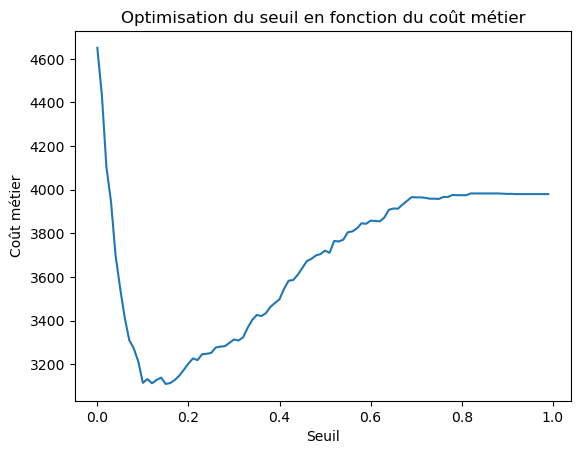

AUC sur l'ensemble de test : 0.6857
Recall sur l'ensemble de test : 0.5352
Accuracy pour la classe 1 sur l'ensemble de test : 0.7137
Custom cost sur l'ensemble de test : 3110.0000
Matrice de confusion sur l'ensemble de test :
[[3390 1260]
 [ 185  213]]
AUC sur l'ensemble d'entraînement : 0.7048
Recall sur l'ensemble d'entraînement : 0.5522
Accuracy pour la classe 1 sur l'ensemble d'entraînement : 0.7164
Custom cost sur l'ensemble d'entraînement : 12709.0000
Matrice de confusion sur l'ensemble d'entraînement :
[[13507  4949]
 [  776   957]]


2024/11/24 00:22:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/24 00:22:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run Logistic Regression / SMOTE-NC / PCA at: http://127.0.0.1:5000/#/experiments/0/runs/63dd9096c96e457699fb24926a426106.
2024/11/24 00:22:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0.


In [114]:
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, roc_auc_score, confusion_matrix
from sklearn.decomposition import PCA
import mlflow
import mlflow.sklearn
import numpy as np

# Définir l'URL de suivi pour MLflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")


# Démarrer un run MLflow pour suivre une expérimentation
with mlflow.start_run(run_name="Logistic Regression / SMOTE-NC / PCA"):
    # Étape 1 : SMOTENC avant PCA
    smote_nc = SMOTENC(categorical_features=discrete_indices, random_state=42)

    # Étape 2 : PCA après sur-échantillonnage
    pca = PCA(n_components=0.95, random_state=42)  # Capture 95% de la variance

    # Étape 3 : Modèle de régression logistique
    log_reg = LogisticRegression(max_iter=1000)


    # Création du pipeline avec SMOTENC, PCA, et régression logistique
    pipeline = Pipeline([
        ('smote', smote_nc),  # Sur-échantillonnage
        ('pca', pca),         # Réduction dimensionnelle
        ('model', log_reg)    # Modèle
    ])

    # Définir l'espace de recherche pour GridSearchCV
    param_grid = {
        'model__C': [0.1],  # Exemple de régularisation
        'model__penalty': ['l2'],      # Types de régularisation
        'model__solver': ['saga'],     # Solver 'saga' compatible avec l1 et l2
        'model__class_weight': ['balanced']  # Gérer le déséquilibre de classe
    }
    
    # Définir la validation croisée avec GridSearchCV
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring=cost_scorer,  # Utiliser votre fonction de coût personnalisée
        cv=5,  # Validation croisée 5-fold
        verbose=1,  # Afficher les informations détaillées
        n_jobs=-1   # Utiliser tous les cœurs disponibles
    )
    
    # Entraîner GridSearchCV (les données synthétiques ne sont générées que pour les données d'entraînement dans chaque pli)
    grid_search.fit(X_train, y_train)

    # Afficher les meilleurs paramètres trouvés
    best_params = grid_search.best_params_
    print(f"Meilleurs paramètres: {best_params}")
    mlflow.log_params(best_params)

    # Utiliser le meilleur modèle pour faire des prédictions sur le jeu de test
    best_model = grid_search.best_estimator_
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]

    # Trouver le seuil optimal basé sur le coût métier
    optimal_threshold, min_cost = find_optimal_threshold(y_test, y_pred_proba, fn_cost=10, fp_cost=1)

    # Appliquer le seuil optimal pour obtenir des prédictions binaires
    y_pred_optimized = (y_pred_proba >= optimal_threshold).astype(int)

    # Obtenir les prédictions optimisées sur l'ensemble d'entraînement
    y_pred_train_proba = best_model.predict_proba(X_train)[:, 1]  # Probabilités pour la classe positive
    # Appliquer le seuil optimal pour générer les prédictions binaires sur l'ensemble d'entraînement
    y_pred_train_optimized = (y_pred_train_proba >= optimal_threshold).astype(int)
    
    # Calcul des métriques pour X_test
    logreg_recall_test = recall_score(y_test, y_pred_optimized)
    logreg_accuracy_test = accuracy_score(y_test, y_pred_optimized)
    auc_score_test = roc_auc_score(y_test, y_pred_proba)
    cost_with_optimal_threshold_test = custom_cost_function(y_test, y_pred_optimized, fn_cost=10, fp_cost=1)
    conf_matrix_test = confusion_matrix(y_test, y_pred_optimized)
    
    # Calcul des métriques pour X_train
    logreg_recall_train = recall_score(y_train, y_pred_train_optimized)
    logreg_accuracy_train = accuracy_score(y_train, y_pred_train_optimized)
    auc_score_train = roc_auc_score(y_train, y_pred_train_proba)
    cost_with_optimal_threshold_train = custom_cost_function(y_train, y_pred_train_optimized, fn_cost=10, fp_cost=1)
    conf_matrix_train = confusion_matrix(y_train, y_pred_train_optimized)
    
    # Affichage des résultats pour X_test
    print(f"AUC sur l'ensemble de test : {auc_score_test:.4f}")
    print(f"Recall sur l'ensemble de test : {logreg_recall_test:.4f}")
    print(f"Accuracy pour la classe 1 sur l'ensemble de test : {logreg_accuracy_test:.4f}")
    print(f"Custom cost sur l'ensemble de test : {cost_with_optimal_threshold_test:.4f}")
    print("Matrice de confusion sur l'ensemble de test :")
    print(conf_matrix_test)
    
    # Affichage des résultats pour X_train
    print(f"AUC sur l'ensemble d'entraînement : {auc_score_train:.4f}")
    print(f"Recall sur l'ensemble d'entraînement : {logreg_recall_train:.4f}")
    print(f"Accuracy pour la classe 1 sur l'ensemble d'entraînement : {logreg_accuracy_train:.4f}")
    print(f"Custom cost sur l'ensemble d'entraînement : {cost_with_optimal_threshold_train:.4f}")
    print("Matrice de confusion sur l'ensemble d'entraînement :")
    print(conf_matrix_train)
    
    # Enregistrer les métriques dans MLflow pour le jeu de test
    mlflow.log_metric("auc_test", auc_score_test)
    mlflow.log_metric("recall_test", logreg_recall_test)
    mlflow.log_metric("accuracy_class1_test", logreg_accuracy_test)
    mlflow.log_metric("custom_cost_test", cost_with_optimal_threshold_test)
    
    # Enregistrer les métriques dans MLflow pour le jeu d'entraînement
    mlflow.log_metric("auc_train", auc_score_train)
    mlflow.log_metric("recall_train", logreg_recall_train)
    mlflow.log_metric("accuracy_class1_train", logreg_accuracy_train)
    mlflow.log_metric("custom_cost_train", cost_with_optimal_threshold_train)
    mlflow.sklearn.log_model(best_model, "best_model")

# Polynomial Feature

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Meilleurs paramètres: {'model__C': 0.1, 'model__class_weight': 'balanced', 'model__penalty': 'l2', 'model__solver': 'saga'}


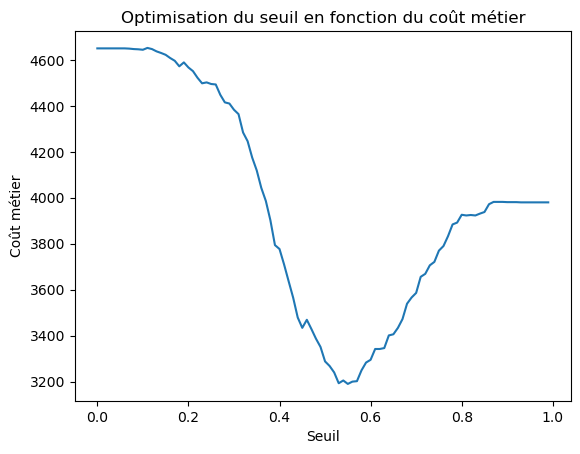

AUC sur l'ensemble de test : 0.6544
Recall sur l'ensemble de test : 0.4799
Accuracy pour la classe 1 sur l'ensemble de test : 0.7371
Custom cost sur l'ensemble de test : 3190.0000
Matrice de confusion sur l'ensemble de test :
[[3530 1120]
 [ 207  191]]
AUC sur l'ensemble d'entraînement : 0.6664
Recall sur l'ensemble d'entraînement : 0.4761
Accuracy pour la classe 1 sur l'ensemble d'entraînement : 0.7286
Custom cost sur l'ensemble d'entraînement : 13652.0000
Matrice de confusion sur l'ensemble d'entraînement :
[[13884  4572]
 [  908   825]]


2024/11/24 00:27:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/24 00:27:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run Logistic Regression PCA/ Polynomial Feature / PCA at: http://127.0.0.1:5000/#/experiments/0/runs/2a7daaaedfcb44e58dcafb2548b635dd.
2024/11/24 00:27:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0.


In [116]:
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, roc_auc_score, confusion_matrix
from sklearn.decomposition import PCA
import mlflow
import mlflow.sklearn
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

# Définir l'URL de suivi pour MLflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")


# Démarrer un run MLflow pour suivre une expérimentation
with mlflow.start_run(run_name="Logistic Regression PCA/ Polynomial Feature / PCA"):
    # Étape 1 : Réduction de dimension initiale (PCA 1)
    pca1 = PCA(n_components=50, random_state=42)  
    
    # Étape 2 : Ajout d'interactions polynomiales
    poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    
    # Étape 3 : Réduction de dimension après Polynomial Features (PCA 2)
    pca2 = PCA(n_components=30, random_state=42)  
    
    # Étape 4 : Modèle final
    log_reg = LogisticRegression(max_iter=1000)
    
    # Créer un pipeline avec PCA, PolynomialFeatures, et le modèle final
    pipeline = Pipeline([
        ('pca1', pca1),
        ('poly', poly),
        ('pca2', pca2),
        ('model', log_reg)
    ])
    
    # Définir la validation croisée avec GridSearchCV
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring=cost_scorer,  # Utiliser votre fonction de coût personnalisée
        cv=5,  # Validation croisée 5-fold
        verbose=1,  # Afficher les informations détaillées
        n_jobs=-1   # Utiliser tous les cœurs disponibles
    )
    
    # Entraîner GridSearchCV (les données synthétiques ne sont générées que pour les données d'entraînement dans chaque pli)
    grid_search.fit(X_train, y_train)

    # Afficher les meilleurs paramètres trouvés
    best_params = grid_search.best_params_
    print(f"Meilleurs paramètres: {best_params}")
    mlflow.log_params(best_params)

    # Utiliser le meilleur modèle pour faire des prédictions sur le jeu de test
    best_model = grid_search.best_estimator_
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]

    # Trouver le seuil optimal basé sur le coût métier
    optimal_threshold, min_cost = find_optimal_threshold(y_test, y_pred_proba, fn_cost=10, fp_cost=1)

    # Appliquer le seuil optimal pour obtenir des prédictions binaires
    y_pred_optimized = (y_pred_proba >= optimal_threshold).astype(int)

    # Obtenir les prédictions optimisées sur l'ensemble d'entraînement
    y_pred_train_proba = best_model.predict_proba(X_train)[:, 1]  # Probabilités pour la classe positive
    # Appliquer le seuil optimal pour générer les prédictions binaires sur l'ensemble d'entraînement
    y_pred_train_optimized = (y_pred_train_proba >= optimal_threshold).astype(int)
    
    # Calcul des métriques pour X_test
    logreg_recall_test = recall_score(y_test, y_pred_optimized)
    logreg_accuracy_test = accuracy_score(y_test, y_pred_optimized)
    auc_score_test = roc_auc_score(y_test, y_pred_proba)
    cost_with_optimal_threshold_test = custom_cost_function(y_test, y_pred_optimized, fn_cost=10, fp_cost=1)
    conf_matrix_test = confusion_matrix(y_test, y_pred_optimized)
    
    # Calcul des métriques pour X_train
    logreg_recall_train = recall_score(y_train, y_pred_train_optimized)
    logreg_accuracy_train = accuracy_score(y_train, y_pred_train_optimized)
    auc_score_train = roc_auc_score(y_train, y_pred_train_proba)
    cost_with_optimal_threshold_train = custom_cost_function(y_train, y_pred_train_optimized, fn_cost=10, fp_cost=1)
    conf_matrix_train = confusion_matrix(y_train, y_pred_train_optimized)
    
    # Affichage des résultats pour X_test
    print(f"AUC sur l'ensemble de test : {auc_score_test:.4f}")
    print(f"Recall sur l'ensemble de test : {logreg_recall_test:.4f}")
    print(f"Accuracy pour la classe 1 sur l'ensemble de test : {logreg_accuracy_test:.4f}")
    print(f"Custom cost sur l'ensemble de test : {cost_with_optimal_threshold_test:.4f}")
    print("Matrice de confusion sur l'ensemble de test :")
    print(conf_matrix_test)
    
    # Affichage des résultats pour X_train
    print(f"AUC sur l'ensemble d'entraînement : {auc_score_train:.4f}")
    print(f"Recall sur l'ensemble d'entraînement : {logreg_recall_train:.4f}")
    print(f"Accuracy pour la classe 1 sur l'ensemble d'entraînement : {logreg_accuracy_train:.4f}")
    print(f"Custom cost sur l'ensemble d'entraînement : {cost_with_optimal_threshold_train:.4f}")
    print("Matrice de confusion sur l'ensemble d'entraînement :")
    print(conf_matrix_train)
    
    # Enregistrer les métriques dans MLflow pour le jeu de test
    mlflow.log_metric("auc_test", auc_score_test)
    mlflow.log_metric("recall_test", logreg_recall_test)
    mlflow.log_metric("accuracy_class1_test", logreg_accuracy_test)
    mlflow.log_metric("custom_cost_test", cost_with_optimal_threshold_test)
    
    # Enregistrer les métriques dans MLflow pour le jeu d'entraînement
    mlflow.log_metric("auc_train", auc_score_train)
    mlflow.log_metric("recall_train", logreg_recall_train)
    mlflow.log_metric("accuracy_class1_train", logreg_accuracy_train)
    mlflow.log_metric("custom_cost_train", cost_with_optimal_threshold_train)
    mlflow.sklearn.log_model(best_model, "best_model")


# Random Forest

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Meilleurs paramètres: {'class_weight': 'balanced', 'max_depth': 3, 'n_estimators': 1000}


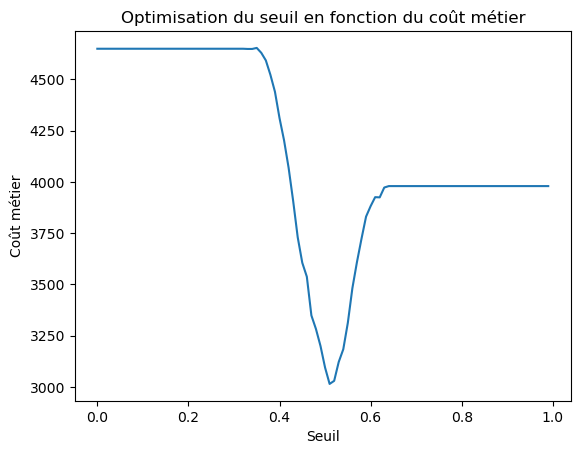

AUC sur l'ensemble de test : 0.6929
Recall sur l'ensemble de test : 0.5276
Accuracy pour la classe 1 sur l'ensemble de test : 0.7379
Custom cost sur l'ensemble de test : 3015.0000
Matrice de confusion sur l'ensemble de test :
[[3515 1135]
 [ 188  210]]
AUC sur l'ensemble d'entraînement : 0.7487
Recall sur l'ensemble d'entraînement : 0.5943
Accuracy pour la classe 1 sur l'ensemble d'entraînement : 0.7466
Custom cost sur l'ensemble d'entraînement : 11442.0000
Matrice de confusion sur l'ensemble d'entraînement :
[[14044  4412]
 [  703  1030]]


2024/11/24 00:45:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/24 00:45:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run Random Forest Classifier at: http://127.0.0.1:5000/#/experiments/0/runs/f849afb0bacf45f5afc72122e4e71e88.
2024/11/24 00:45:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0.


In [118]:
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, confusion_matrix
import numpy as np

# Définir l'URL de suivi (ici, c'est ton serveur MLflow local)
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Démarrer un run MLflow pour suivre une expérimentation
with mlflow.start_run(run_name="Random Forest Classifier"):
    # Espace de recherche des hyperparamètres pour la Random Forest
    param_grid = {
        'n_estimators': [1000],       # Nombre d'arbres
        'max_depth': [3],      # Profondeur des arbres
        'class_weight': ['balanced']      # Prendre en compte le déséquilibre de classe
    }
    
    # Créer le modèle Random Forest
    rf = RandomForestClassifier(random_state=42)
    
    # Définir la validation croisée avec GridSearchCV
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        scoring=cost_scorer,  # Utiliser l'AUC-ROC comme métrique d'évaluation
        cv=5,  # Validation croisée 5-fold
        verbose=1,  # Affiche les détails de la recherche
        n_jobs=-1  # Utilise tous les cœurs disponibles pour accélérer le calcul
    )
    
    # Entraîner GridSearchCV
    grid_search.fit(X_train, y_train)

    # Afficher les meilleurs paramètres trouvés
    best_params = grid_search.best_params_
    print(f"Meilleurs paramètres: {best_params}")

    # Enregistrer les meilleurs hyperparamètres dans MLflow
    mlflow.log_params(best_params)

    # Utiliser les meilleurs paramètres pour prédire sur les données de test
    best_model = grid_search.best_estimator_
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    
    # Trouver le seuil optimal
    optimal_threshold, min_cost = find_optimal_threshold(y_test, y_pred_proba, fn_cost=10, fp_cost=1)   
   
    # Prédictions avec le seuil optimisé
    y_pred_optimized = (y_pred_proba >= optimal_threshold).astype(int)

    # Obtenir les prédictions optimisées sur l'ensemble d'entraînement
    y_pred_train_proba = best_model.predict_proba(X_train)[:, 1]  # Probabilités pour la classe positive
    # Appliquer le seuil optimal pour générer les prédictions binaires sur l'ensemble d'entraînement
    y_pred_train_optimized = (y_pred_train_proba >= optimal_threshold).astype(int)
    
    # Calcul des métriques pour X_test
    logreg_recall_test = recall_score(y_test, y_pred_optimized)
    logreg_accuracy_test = accuracy_score(y_test, y_pred_optimized)
    auc_score_test = roc_auc_score(y_test, y_pred_proba)
    cost_with_optimal_threshold_test = custom_cost_function(y_test, y_pred_optimized, fn_cost=10, fp_cost=1)
    conf_matrix_test = confusion_matrix(y_test, y_pred_optimized)
    
    # Calcul des métriques pour X_train
    logreg_recall_train = recall_score(y_train, y_pred_train_optimized)
    logreg_accuracy_train = accuracy_score(y_train, y_pred_train_optimized)
    auc_score_train = roc_auc_score(y_train, y_pred_train_proba)
    cost_with_optimal_threshold_train = custom_cost_function(y_train, y_pred_train_optimized, fn_cost=10, fp_cost=1)
    conf_matrix_train = confusion_matrix(y_train, y_pred_train_optimized)
    
    # Affichage des résultats pour X_test
    print(f"AUC sur l'ensemble de test : {auc_score_test:.4f}")
    print(f"Recall sur l'ensemble de test : {logreg_recall_test:.4f}")
    print(f"Accuracy pour la classe 1 sur l'ensemble de test : {logreg_accuracy_test:.4f}")
    print(f"Custom cost sur l'ensemble de test : {cost_with_optimal_threshold_test:.4f}")
    print("Matrice de confusion sur l'ensemble de test :")
    print(conf_matrix_test)
    
    # Affichage des résultats pour X_train
    print(f"AUC sur l'ensemble d'entraînement : {auc_score_train:.4f}")
    print(f"Recall sur l'ensemble d'entraînement : {logreg_recall_train:.4f}")
    print(f"Accuracy pour la classe 1 sur l'ensemble d'entraînement : {logreg_accuracy_train:.4f}")
    print(f"Custom cost sur l'ensemble d'entraînement : {cost_with_optimal_threshold_train:.4f}")
    print("Matrice de confusion sur l'ensemble d'entraînement :")
    print(conf_matrix_train)
    
    # Enregistrer les métriques dans MLflow pour le jeu de test
    mlflow.log_metric("auc_test", auc_score_test)
    mlflow.log_metric("recall_test", logreg_recall_test)
    mlflow.log_metric("accuracy_class1_test", logreg_accuracy_test)
    mlflow.log_metric("custom_cost_test", cost_with_optimal_threshold_test)
    
    # Enregistrer les métriques dans MLflow pour le jeu d'entraînement
    mlflow.log_metric("auc_train", auc_score_train)
    mlflow.log_metric("recall_train", logreg_recall_train)
    mlflow.log_metric("accuracy_class1_train", logreg_accuracy_train)
    mlflow.log_metric("custom_cost_train", cost_with_optimal_threshold_train)

    # Enregistrer le modèle dans MLflow
    mlflow.sklearn.log_model(best_model, "best_model")


# LightGBM

Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\mauge\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\mauge\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[LightGBM] [Info] Number of positive: 1733, number of negative: 18456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47924
[LightGBM] [Info] Number of data points in the train set: 20189, number of used features: 482
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085839 -> initscore=-2.365536
[LightGBM] [Info] Start training from score -2.365536
Meilleurs paramètres: {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'n_estimators': 500, 'objective': 'binary'}


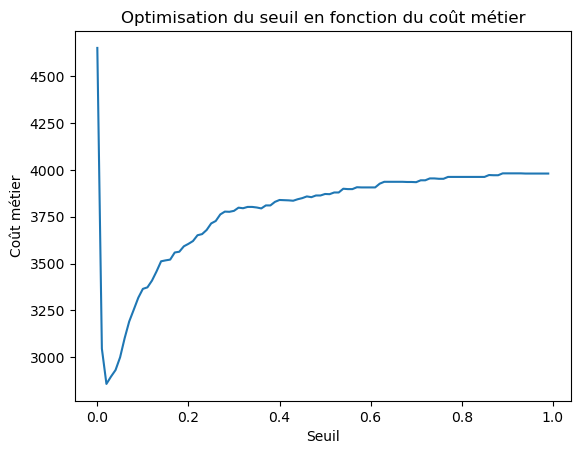

AUC sur l'ensemble de test : 0.7149
Recall sur l'ensemble de test : 0.6281
Accuracy pour la classe 1 sur l'ensemble de test : 0.6977
Custom cost sur l'ensemble de test : 2858.0000
Matrice de confusion sur l'ensemble de test :
[[3272 1378]
 [ 148  250]]
AUC sur l'ensemble d'entraînement : 1.0000
Recall sur l'ensemble d'entraînement : 1.0000
Accuracy pour la classe 1 sur l'ensemble d'entraînement : 0.8972
Custom cost sur l'ensemble d'entraînement : 2076.0000
Matrice de confusion sur l'ensemble d'entraînement :
[[16380  2076]
 [    0  1733]]


2024/11/24 00:50:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/11/24 00:50:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run LightGBM  at: http://127.0.0.1:5000/#/experiments/0/runs/08429e2531564d44aa416d7b6579f4d2.
2024/11/24 00:50:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0.


In [121]:
import mlflow
import mlflow.sklearn
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, confusion_matrix


# Définir l'URL de suivi (ici, c'est ton serveur MLflow local)
mlflow.set_tracking_uri("http://127.0.0.1:5000")
# Démarrer un run MLflow pour LightGBM
with mlflow.start_run(run_name="LightGBM "):

    # Espace de recherche des hyperparamètres pour LightGBM
    param_grid = {
        'learning_rate': [0.1],
        'n_estimators': [500],
        'boosting_type': ['gbdt'],  # Gradient Boosting Decision Trees
        'objective': ['binary'],  # Problème de classification binaire
    }

    # Créer le modèle LightGBM
    lgbm = lgb.LGBMClassifier()

    # Utiliser GridSearchCV pour LightGBM avec le cost_scorer
    grid_search = GridSearchCV(
        estimator=lgbm,
        param_grid=param_grid,
        scoring=cost_scorer,  # Utiliser la fonction de coût comme métrique d'évaluation
        cv=5,  # Validation croisée
        verbose=1,
        n_jobs=-1  # Utiliser tous les cœurs disponibles pour accélérer le calcul
    )
    
    # Entraîner GridSearchCV
    grid_search.fit(X_train, y_train)

    # Afficher les meilleurs paramètres trouvés
    best_params = grid_search.best_params_
    print(f"Meilleurs paramètres: {best_params}")

    # Enregistrer les meilleurs hyperparamètres dans MLflow
    mlflow.log_params(best_params)

    # Utiliser les meilleurs paramètres pour prédire sur les données de test
    best_model = grid_search.best_estimator_
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    
    # Trouver le seuil optimal
    optimal_threshold, min_cost = find_optimal_threshold(y_test, y_pred_proba, fn_cost=10, fp_cost=1)   
   
    # Prédictions avec le seuil optimisé
    y_pred_optimized = (y_pred_proba >= optimal_threshold).astype(int)

    # Obtenir les prédictions optimisées sur l'ensemble d'entraînement
    y_pred_train_proba = best_model.predict_proba(X_train)[:, 1]  # Probabilités pour la classe positive
    # Appliquer le seuil optimal pour générer les prédictions binaires sur l'ensemble d'entraînement
    y_pred_train_optimized = (y_pred_train_proba >= optimal_threshold).astype(int)
    
    # Calcul des métriques pour X_test
    logreg_recall_test = recall_score(y_test, y_pred_optimized)
    logreg_accuracy_test = accuracy_score(y_test, y_pred_optimized)
    auc_score_test = roc_auc_score(y_test, y_pred_proba)
    cost_with_optimal_threshold_test = custom_cost_function(y_test, y_pred_optimized, fn_cost=10, fp_cost=1)
    conf_matrix_test = confusion_matrix(y_test, y_pred_optimized)
    
    # Calcul des métriques pour X_train
    logreg_recall_train = recall_score(y_train, y_pred_train_optimized)
    logreg_accuracy_train = accuracy_score(y_train, y_pred_train_optimized)
    auc_score_train = roc_auc_score(y_train, y_pred_train_proba)
    cost_with_optimal_threshold_train = custom_cost_function(y_train, y_pred_train_optimized, fn_cost=10, fp_cost=1)
    conf_matrix_train = confusion_matrix(y_train, y_pred_train_optimized)
    
    # Affichage des résultats pour X_test
    print(f"AUC sur l'ensemble de test : {auc_score_test:.4f}")
    print(f"Recall sur l'ensemble de test : {logreg_recall_test:.4f}")
    print(f"Accuracy pour la classe 1 sur l'ensemble de test : {logreg_accuracy_test:.4f}")
    print(f"Custom cost sur l'ensemble de test : {cost_with_optimal_threshold_test:.4f}")
    print("Matrice de confusion sur l'ensemble de test :")
    print(conf_matrix_test)
    
    # Affichage des résultats pour X_train
    print(f"AUC sur l'ensemble d'entraînement : {auc_score_train:.4f}")
    print(f"Recall sur l'ensemble d'entraînement : {logreg_recall_train:.4f}")
    print(f"Accuracy pour la classe 1 sur l'ensemble d'entraînement : {logreg_accuracy_train:.4f}")
    print(f"Custom cost sur l'ensemble d'entraînement : {cost_with_optimal_threshold_train:.4f}")
    print("Matrice de confusion sur l'ensemble d'entraînement :")
    print(conf_matrix_train)
    
    # Enregistrer les métriques dans MLflow pour le jeu de test
    mlflow.log_metric("auc_test", auc_score_test)
    mlflow.log_metric("recall_test", logreg_recall_test)
    mlflow.log_metric("accuracy_class1_test", logreg_accuracy_test)
    mlflow.log_metric("custom_cost_test", cost_with_optimal_threshold_test)
    
    # Enregistrer les métriques dans MLflow pour le jeu d'entraînement
    mlflow.log_metric("auc_train", auc_score_train)
    mlflow.log_metric("recall_train", logreg_recall_train)
    mlflow.log_metric("accuracy_class1_train", logreg_accuracy_train)
    mlflow.log_metric("custom_cost_train", cost_with_optimal_threshold_train)

    # Enregistrer le modèle dans MLflow
    mlflow.sklearn.log_model(best_model, "best_model")

# Réseau de neuronnes : Multi-Layer Perceptron

In [114]:
from imblearn.over_sampling import SMOTE
# Appliquer SMOTE pour sur-échantillonner la classe minoritaire
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

C:\Users\mauge\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\mauge\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


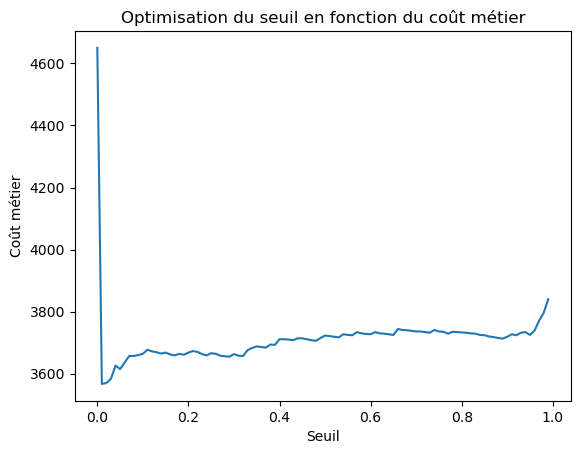

2024/11/24 01:06:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run MLP with PCA at: http://127.0.0.1:5000/#/experiments/0/runs/bf11b8486c95472fa338b5eebd0d0ec9.


AUC sur l'ensemble de test : 0.6374
Recall sur l'ensemble de test : 0.2362
Accuracy pour la classe 1 sur l'ensemble de test : 0.8354
Custom cost sur l'ensemble de test : 3567.0000
Matrice de confusion sur l'ensemble de test :
[[4123  527]
 [ 304   94]]
AUC sur l'ensemble d'entraînement : 1.0000
Recall sur l'ensemble d'entraînement : 1.0000
Accuracy pour la classe 1 sur l'ensemble d'entraînement : 1.0000
Custom cost sur l'ensemble d'entraînement : 1.0000
Matrice de confusion sur l'ensemble d'entraînement :
[[18455     1]
 [    0  1733]]
[[3888  762]
 [ 201  197]]


2024/11/24 01:06:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0.


In [125]:
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, confusion_matrix
import mlflow
import mlflow.sklearn

# Définir l'URL de suivi pour MLflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Démarrer un run MLflow pour suivre une expérimentation
with mlflow.start_run(run_name="MLP with PCA"):

    # Créer un pipeline avec PCA et MLP
    pipeline = Pipeline([
        ('pca', PCA(n_components=0.95)),  # PCA pour réduire la dimensionnalité
        ('mlp', MLPClassifier(
            hidden_layer_sizes=(128, 64, 32),
            activation='relu',
            solver='adam',
            alpha=0.001,
            max_iter=500,
            random_state=42
        ))
    ])

    # Enregistrer les hyperparamètres du modèle MLP dans MLflow
    mlflow.log_params({
        "hidden_layer_sizes": (128, 64, 32),
        "activation": "relu",
        "solver": "adam",
        "alpha": 0.001,
        "max_iter": 500
    })

    # Entraîner le pipeline sur l'ensemble d'entraînement
    pipeline.fit(X_train, y_train)

    # Faire des prédictions probabilistes pour l'optimisation du seuil
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]  # Probabilités de la classe positive

    # Trouver le seuil optimal en minimisant la fonction de coût
    optimal_threshold, min_cost = find_optimal_threshold(y_test, y_pred_proba, fn_cost=10, fp_cost=1)

    # Enregistrer le seuil optimal dans MLflow
    mlflow.log_param("optimal_threshold", optimal_threshold)

    # Prédictions avec le seuil optimisé
    y_pred_optimized = (y_pred_proba >= optimal_threshold).astype(int)

    # Obtenir les prédictions optimisées sur l'ensemble d'entraînement
    y_pred_train_proba = pipeline.predict_proba(X_train)[:, 1]  # Probabilités pour la classe positive
    # Appliquer le seuil optimal pour générer les prédictions binaires sur l'ensemble d'entraînement
    y_pred_train_optimized = (y_pred_train_proba >= optimal_threshold).astype(int)
    
    # Calcul des métriques pour X_test
    logreg_recall_test = recall_score(y_test, y_pred_optimized)
    logreg_accuracy_test = accuracy_score(y_test, y_pred_optimized)
    auc_score_test = roc_auc_score(y_test, y_pred_proba)
    cost_with_optimal_threshold_test = custom_cost_function(y_test, y_pred_optimized, fn_cost=10, fp_cost=1)
    conf_matrix_test = confusion_matrix(y_test, y_pred_optimized)
    
    # Calcul des métriques pour X_train
    logreg_recall_train = recall_score(y_train, y_pred_train_optimized)
    logreg_accuracy_train = accuracy_score(y_train, y_pred_train_optimized)
    auc_score_train = roc_auc_score(y_train, y_pred_train_proba)
    cost_with_optimal_threshold_train = custom_cost_function(y_train, y_pred_train_optimized, fn_cost=10, fp_cost=1)
    conf_matrix_train = confusion_matrix(y_train, y_pred_train_optimized)
    
    # Affichage des résultats pour X_test
    print(f"AUC sur l'ensemble de test : {auc_score_test:.4f}")
    print(f"Recall sur l'ensemble de test : {logreg_recall_test:.4f}")
    print(f"Accuracy pour la classe 1 sur l'ensemble de test : {logreg_accuracy_test:.4f}")
    print(f"Custom cost sur l'ensemble de test : {cost_with_optimal_threshold_test:.4f}")
    print("Matrice de confusion sur l'ensemble de test :")
    print(conf_matrix_test)
    
    # Affichage des résultats pour X_train
    print(f"AUC sur l'ensemble d'entraînement : {auc_score_train:.4f}")
    print(f"Recall sur l'ensemble d'entraînement : {logreg_recall_train:.4f}")
    print(f"Accuracy pour la classe 1 sur l'ensemble d'entraînement : {logreg_accuracy_train:.4f}")
    print(f"Custom cost sur l'ensemble d'entraînement : {cost_with_optimal_threshold_train:.4f}")
    print("Matrice de confusion sur l'ensemble d'entraînement :")
    print(conf_matrix_train)
    
    # Enregistrer les métriques dans MLflow pour le jeu de test
    mlflow.log_metric("auc_test", auc_score_test)
    mlflow.log_metric("recall_test", logreg_recall_test)
    mlflow.log_metric("accuracy_class1_test", logreg_accuracy_test)
    mlflow.log_metric("custom_cost_test", cost_with_optimal_threshold_test)
    
    # Enregistrer les métriques dans MLflow pour le jeu d'entraînement
    mlflow.log_metric("auc_train", auc_score_train)
    mlflow.log_metric("recall_train", logreg_recall_train)
    mlflow.log_metric("accuracy_class1_train", logreg_accuracy_train)
    mlflow.log_metric("custom_cost_train", cost_with_optimal_threshold_train)

    print(conf_matrix)



# Feature Importance globale

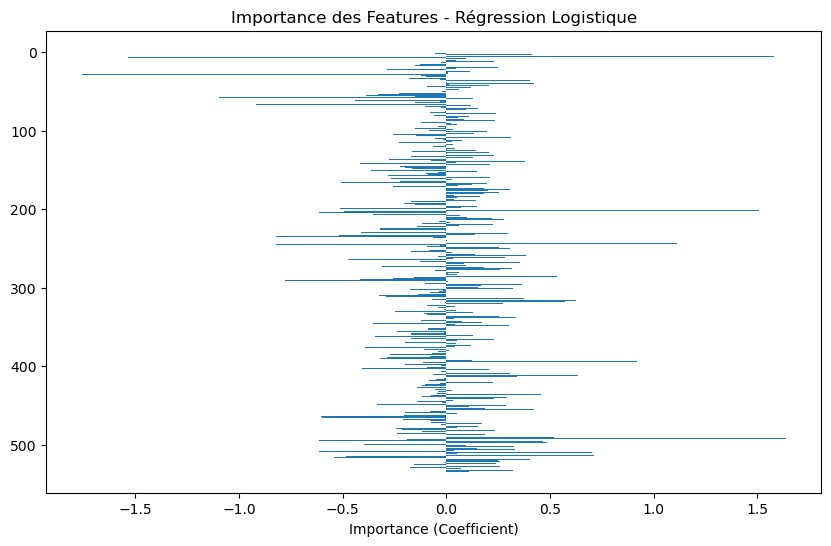

In [48]:
# Vérification si X_train a des noms de colonnes (DataFrame pandas)
if hasattr(X_train, 'columns'):
    feature_names = X_train.columns  # Si c'est un DataFrame pandas, obtenir les noms de colonnes
else:
    num_features = X_train.shape[1]  # Sinon, obtenir le nombre de features
    feature_names = np.arange(num_features)  # Génér
coefficients = best_model.coef_[0]
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': coefficients
})
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

# Affichage de l'importance des features
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance (Coefficient)')
plt.title('Importance des Features - Régression Logistique')
plt.gca().invert_yaxis()
plt.show()

In [49]:
feature_importance.head(10)

,feature,importance
492,492,1.639384
6,6,1.580843
202,202,1.509280
244,244,1.110770
317,317,0.996311
394,394,0.917709
532,532,0.734841
514,514,0.714636
206,206,0.714282
510,510,0.704839


In [50]:
df_feature = df_model.drop(columns=['TARGET','SK_ID_CURR'])

In [51]:
index_top10 = feature_importance.head(10).index
index_flop10 = feature_importance.tail(10).index

In [52]:
df_model.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: typ

In [53]:
X_train.shape

(60570, 535)

In [54]:
df_feature.iloc[:,index_top10]

,APPROVED_CNT_PAYMENT_SUM,AMT_ANNUITY,ANNUITY_INCOME_PERC,BURO_CREDIT_TYPE_Microloan_MEAN,PREV_CNT_PAYMENT_MEAN,PREV_NAME_GOODS_CATEGORY_Direct Sales_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DBD_MAX,BURO_DAYS_CREDIT_MEAN,INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE
33169,6.0,36094.5,0.297074,0.000000,6.000000,0.000000,-1383.163743,30.0,-1708.750000,2.0
257817,24.0,41836.5,0.232425,0.000000,11.333333,0.000000,-2282.113636,32.0,-1259.444444,5.0
36660,32.0,30568.5,0.452867,0.000000,8.000000,0.000000,-561.760000,87.0,-976.600000,1.0
137861,12.0,26109.0,0.128933,0.000000,12.000000,0.000000,-475.500000,46.0,-1240.350000,2.0
249954,32.0,50377.5,0.223900,0.000000,11.000000,0.000000,-1276.653846,39.0,-652.000000,1.0
...,...,...,...,...,...,...,...,...,...,...
248682,64.0,61357.5,0.170437,0.000000,12.800000,0.000000,-1359.718750,37.0,-1073.583333,2.0
10561,54.0,19345.5,0.204714,0.000000,30.000000,0.333333,-212.100000,72.0,-2071.142857,1.0
158609,72.0,14751.0,0.117071,0.055556,17.454545,0.000000,-1014.653846,32.0,-765.555556,8.0
57817,48.0,26784.0,0.238080,NaN,24.000000,0.000000,-285.482143,18.0,NaN,2.0


In [55]:
columns_top10 = df_feature.iloc[:,index_top10].columns
columns_top10

Index(['APPROVED_CNT_PAYMENT_SUM', 'AMT_ANNUITY', 'ANNUITY_INCOME_PERC',
       'BURO_CREDIT_TYPE_Microloan_MEAN', 'PREV_CNT_PAYMENT_MEAN',
       'PREV_NAME_GOODS_CATEGORY_Direct Sales_MEAN',
       'INSTAL_DAYS_ENTRY_PAYMENT_MEAN', 'INSTAL_DBD_MAX',
       'BURO_DAYS_CREDIT_MEAN', 'INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE'],
      dtype='object')

In [56]:
columns_flop10 = df_feature.iloc[:,index_flop10].columns
columns_flop10

Index(['INSTAL_PAYMENT_PERC_MEAN', 'PREV_AMT_ANNUITY_MEAN',
       'BURO_CREDIT_TYPE_Mortgage_MEAN', 'BURO_CREDIT_TYPE_Car loan_MEAN',
       'APPROVED_DAYS_DECISION_MEAN', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       'FLAG_DOCUMENT_18', 'AMT_GOODS_PRICE', 'EXT_SOURCE_2', 'EXT_SOURCE_3'],
      dtype='object')

In [57]:
column_names = df_feature.columns
# La colonne 'feature' contient les indices des colonnes de X_train
feature_importance['nom_colonne'] = feature_importance['feature'].map(lambda idx: column_names[idx])

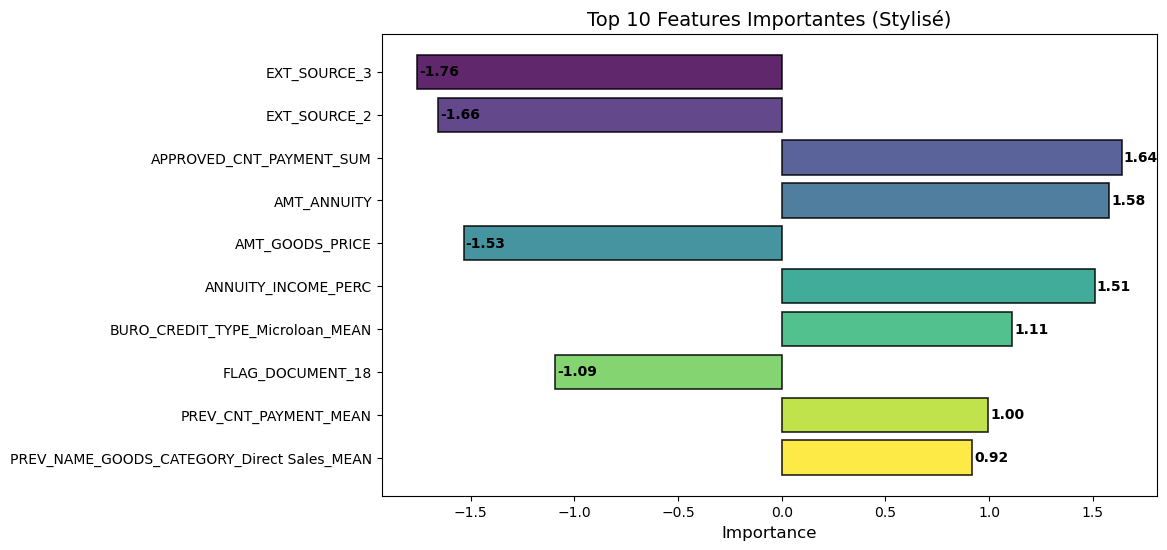

In [58]:
# Trier les features par l'importance absolue et sélectionner les 10 plus importantes
top_features = feature_importance.reindex(feature_importance['importance'].abs().sort_values(ascending=False).index).head(10)

# Création de l'histogramme avec un style plus esthétique
plt.figure(figsize=(10, 6))

# Couleurs avec un gradient pour ajouter de la profondeur
colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))

# Création des barres avec un style de relief et bordure
bars = plt.barh(top_features['nom_colonne'], top_features['importance'], color=colors, edgecolor='black', linewidth=1.5)

# Ajouter de l'ombre pour un effet 3D
for bar in bars:
    bar.set_linewidth(1.2)
    bar.set_edgecolor('black')
    bar.set_alpha(0.85)  # Ajuster la transparence pour un effet de profondeur

# Ajouter les valeurs numériques sur les barres
for i, (importance, feature) in enumerate(zip(top_features['importance'], top_features['nom_colonne'])):
    plt.text(importance + 0.01, i, f'{importance:.2f}', va='center', fontsize=10, fontweight='bold', color='black')

# Ajouter des labels et un titre
plt.xlabel('Importance', fontsize=12)
plt.title('Top 10 Features Importantes (Stylisé)', fontsize=14)

# Inverser l'axe Y pour avoir la plus grande importance en haut
plt.gca().invert_yaxis()

# Afficher le graphique
plt.show()

In [59]:
top_features.to_csv('top_features.csv', index=False)

# Feature Importance locale 'client'

In [98]:
feature_names = df_model.drop(columns=['TARGET','SK_ID_CURR']).columns
X_train = pd.DataFrame(X_train, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)

In [45]:
import joblib
# Remplacez "path/to/your/model.pkl" par le chemin réel vers votre fichier .pkl
model_retenu = joblib.load(r"C:\Users\mauge\Openclassrooms\Projet 7 - Git repository\app\linear_regression_model.pkl")
pipeline_retenu = joblib.load(r"C:\Users\mauge\Openclassrooms\Projet 7 - Git repository\app\preprocessing_pipeline.pkl")


In [49]:
X_train_processed = pipeline_retenu.transform(X_train)
X_test_processed = pipeline_retenu.transform(X_test)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=df_model.drop(columns=['TARGET', 'SK_ID_CURR']) .columns)


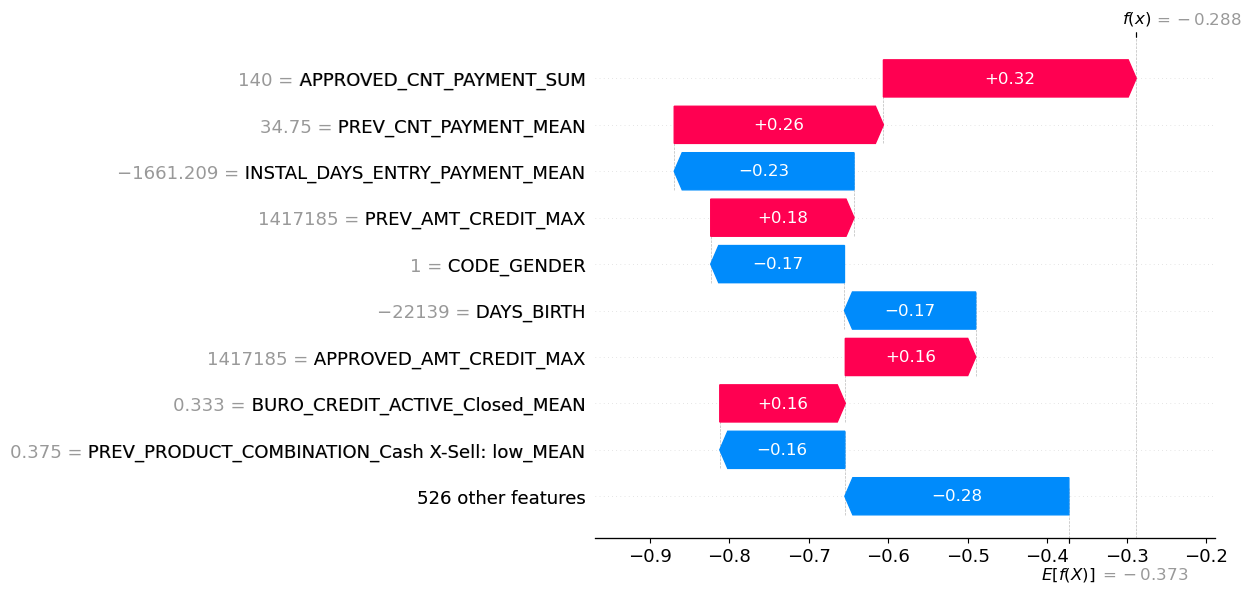

In [50]:
import shap
import matplotlib.pyplot as plt

# Créer un explainer SHAP pour un modèle linéaire comme la régression logistique
explainer = shap.LinearExplainer(model_retenu, X_train_processed)

# Calculer les valeurs de SHAP pour l'ensemble des observations de X_test
shap_values = explainer.shap_values(X_test_processed)

# Sélectionner l'observation
index_observation = 0
observation = X_test.iloc[index_observation]

# Force plot
shap.force_plot(explainer.expected_value, shap_values[index_observation], observation)

# Waterfall plot en utilisant directement les noms des colonnes
explanation = shap.Explanation(values=shap_values[index_observation], 
                               base_values=explainer.expected_value, 
                               data=observation, 
                               feature_names=X_test_processed_df.columns)

# Visualiser l'importance locale des features avec un waterfall plot
shap.plots.waterfall(explanation)

In [51]:
# Sauvegarder l'explainer avec joblib
joblib.dump(explainer, "shap_explainer.joblib")

['shap_explainer.joblib']

# Data Drift

In [153]:
df_sample.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: typ

In [164]:
df_model = df_sample.copy()

# Median imputation of missing values
imputer = SimpleImputer(strategy = 'median')

# Supposons que df soit votre DataFrame avec les features et la cible
X_drift = df_model.drop(columns=['SK_ID_CURR']).copy()  # Features

# Fit on the training data
imputer.fit(X_drift)

# Transform both training and testing data
X_drift_imputed = imputer.transform(X_drift)

In [166]:
# Recréer le DataFrame avec les indices et noms de colonnes originaux
X_drift_df = pd.DataFrame(X_drift_imputed, index=X_drift.index, columns=X_drift.columns)

In [168]:
sample_size = 0.05
# Diviser les données en ensemble d'entraînement et de test de manière stratifiée
X_train, _ = train_test_split(X_drift_df, test_size=1-sample_size, random_state=4)

# Afficher les dimensions des ensembles
print("Ensemble d'entraînement:", X_train.shape)

Ensemble d'entraînement: (3785, 536)


In [170]:
(X_train['TARGET'] == 1).mean()

0.0845442536327609

In [149]:
X_train[X_train.isna().any(axis=1)]

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZ

In [171]:
X_train.shape

(3785, 536)

In [173]:
X_train = X_train.sort_index()
X_train.head()

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZ

C:\Users\mauge\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning:

invalid value encountered in divide

C:\Users\mauge\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning:

invalid value encountered in divide

C:\Users\mauge\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning:

invalid value encountered in divide

C:\Users\mauge\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning:

invalid value encountered in divide

C:\Users\mauge\anaconda3\Lib\site-packages\evidently\calculations\stattests\ks_stattest.py:49: RuntimeWarning:

ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.

C:\Users\mauge\anaconda3\Lib\site-packages\evidently\calculations\stattests\ks_stattest.py:49: RuntimeWarning:

ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.

C:\Users\mauge\anaconda3\Lib\site-packages\evidently\calculations\stattests\ks_stattest.py:49: RuntimeWarning:

ks_2

    index  drift_score
0     300          0.5
1     600          0.5
2     900          0.5
3    1200          0.5
4    1500          0.5
5    1800          0.5
6    2100          0.5
7    2400          0.5
8    2700          0.5
9    3000          0.5
10   3300          0.5
11   3600          0.5


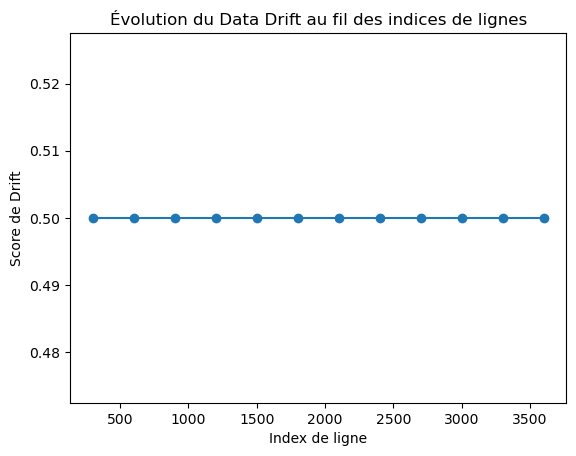

In [174]:
import pandas as pd
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset
import matplotlib.pyplot as plt

# Supposons que votre DataFrame s'appelle 'data'
# Définissez la période de référence
window_size = 300  # Taille de chaque fenêtre
reference_data = X_train.iloc[:window_size]  # Première fenêtre comme référence

# Liste pour stocker les scores de drift au fil du temps
drift_scores = []

# Itérez sur chaque fenêtre de données incrémentales
for start_idx in range(window_size, len(X_train), window_size):
    # Définir la fenêtre actuelle de données
    current_data = X_train.iloc[start_idx:start_idx + window_size]
    
    # Vérifiez que la fenêtre n'est pas vide
    if current_data.empty:
        continue
    
    # Vérifiez les valeurs nulles
    if reference_data.isnull().values.any() or current_data.isnull().values.any():
        print(f"Valeurs nulles détectées dans la fenêtre {start_idx}, ignorée.")
        continue
        
    # Créer un rapport de drift pour la fenêtre actuelle
    data_drift_report = Report(metrics=[DataDriftPreset()])
    data_drift_report.run(reference_data=reference_data, current_data=current_data)
    
    # Extraire le score de drift global (ou d'autres métriques si souhaité)
    drift_result = data_drift_report.as_dict()
    drift_score = drift_result['metrics'][0]['result']['drift_share']  # Par exemple, le pourcentage de features en drift
    drift_scores.append({'index': start_idx, 'drift_score': drift_score})

# Convertir les scores de drift en DataFrame pour visualisation
drift_df = pd.DataFrame(drift_scores)
print(drift_df)

# Visualiser l’évolution du drift au fil des indices de lignes
plt.plot(drift_df['index'], drift_df['drift_score'], marker='o')
plt.title("Évolution du Data Drift au fil des indices de lignes")
plt.xlabel("Index de ligne")
plt.ylabel("Score de Drift")
plt.show()


In [175]:
# Un drift_score de 0.5 suggère qu'il y a une probabilité de 50% que la distribution des données ait changé entre les périodes comparées. C’est souvent une indication d’un drift neutre ou incertain : il y a un niveau de changement, mais pas assez pour confirmer un fort décalage ni assez faible pour garantir une stabilité parfaite.

# Exports

In [ ]:
X_test_df = pd.DataFrame(X_test, columns=df_model.drop(columns=['TARGET', 'SK_ID_CURR']).columns)


(252379, 537)

In [52]:
# Taille de l'échantillon souhaitée
sample_size = 0.001

# Création de l'échantillon avec stratification pour respecter les proportions dans la colonne 'TARGET'
df_export, _ = train_test_split(df_model, test_size=1-sample_size, stratify=df_model['TARGET'], random_state=42)

In [54]:
df_export = df_export.drop(columns='TARGET')

In [55]:
df_export.shape

(75, 536)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler



# Définition des features et de la cible
X = df_export.drop(columns=['TARGET', 'SK_ID_CURR'])
y = df_export['TARGET']
sk_id_curr = df_export['SK_ID_CURR']  # On sauvegarde la colonne SK_ID_CURR

# Division en ensemble d'entraînement et de test de manière stratifiée
X_train, X_test, y_train, y_test, sk_id_curr_train, sk_id_curr_test = train_test_split(
    X, y, sk_id_curr, test_size=0.2, stratify=y, random_state=4
)

# Transformation de X_test en DataFrame avec les noms de colonnes originaux (hors TARGET et SK_ID_CURR)
X_test_df = pd.DataFrame(X_test, columns=df_model.drop(columns=['TARGET', 'SK_ID_CURR']).columns)

# Ajout de la colonne SK_ID_CURR correspondante
X_test_df['SK_ID_CURR'] = sk_id_curr_test.reset_index(drop=True)

# Vérification du résultat
print(X_test_df.head())


   CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  \
0          1.0           1.0              1.0      0.052632          0.090909   
1          1.0           0.0              0.0      0.000000          0.082373   
2          1.0           0.0              1.0      0.000000          0.103713   
3          0.0           0.0              0.0      0.000000          0.019787   
4          0.0           1.0              1.0      0.000000          0.167734   

   AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
0    0.103547     0.068020         0.107143                    0.392880   
1    0.161073     0.094866         0.166667                    0.248124   
2    0.264159     0.139827         0.226190                    0.446855   
3    0.027741     0.070335         0.026190                    0.094575   
4    0.188409     0.216705         0.166667                    0.260475   

   DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLI

In [ ]:
# Étape 1 : Remplacer les NaN par une valeur arbitraire (-9999 par exemple)
#df_safe = df_export.fillna(-9999)
df_safe = df_export.replace(True,1)
df_safe = df_safe.replace(False,0)

In [75]:
df_safe.head()

,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORG

In [66]:
#Sauvegarder le DataFrame en un fichier JSON
df_safe.to_json("df_export.json", orient="records", indent=4)

In [73]:
import json
# Convertir en JSON avec allow_nan=True
json_data = json.dumps(df_safe.to_dict(orient='records'), allow_nan=True)

In [74]:
# Écrire dans un fichier JSON
with open('df_export_2.json', 'w') as file:
    file.write(json_data)

In [71]:
data = pd.read_json(df_export_2.json)

NameError: name 'df_export_2' is not defined

In [54]:
X_test['SK_ID_CURR'].isna().mean()

1.0

In [92]:
import joblib
# Sauvegarder le modèle
joblib.dump(best_model, 'linear_regression_model.pkl')

['linear_regression_model.pkl']

In [166]:
import json
# Extraire la première ligne (ligne 0) sous forme de liste
features = X_test[0].tolist()
# Préparer les données au format JSON avec la clé "features"
data = {'features': features}

# Exporter les données dans un fichier JSON avec la clé "features"
with open('exported_features.json', 'w') as f:
    json.dump(data, f)

In [62]:

# Importer depuis JSON
df_loaded = pd.read_json(r"C:\Users\mauge\Openclassrooms\Projet 7 - Git repository\df_export.json")

# Afficher toutes les colonnes booléennes
bool_columns = df_loaded.select_dtypes(include=['bool'])
print(f"Colonnes booléennes : {bool_columns.columns.tolist()}")

# Ou pour afficher avec leurs types
print("Types des colonnes :")
print(df_loaded.dtypes)



Colonnes booléennes : ['NAME_CONTRACT_TYPE_Cash loans', 'NAME_CONTRACT_TYPE_Revolving loans', 'NAME_TYPE_SUITE_Children', 'NAME_TYPE_SUITE_Family', 'NAME_TYPE_SUITE_Group of people', 'NAME_TYPE_SUITE_Other_A', 'NAME_TYPE_SUITE_Other_B', 'NAME_TYPE_SUITE_Spouse, partner', 'NAME_TYPE_SUITE_Unaccompanied', 'NAME_INCOME_TYPE_Commercial associate', 'NAME_INCOME_TYPE_Maternity leave', 'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Student', 'NAME_INCOME_TYPE_Unemployed', 'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Academic degree', 'NAME_EDUCATION_TYPE_Higher education', 'NAME_EDUCATION_TYPE_Incomplete higher', 'NAME_EDUCATION_TYPE_Lower secondary', 'NAME_EDUCATION_TYPE_Secondary / secondary special', 'NAME_FAMILY_STATUS_Civil marriage', 'NAME_FAMILY_STATUS_Married', 'NAME_FAMILY_STATUS_Separated', 'NAME_FAMILY_STATUS_Single / not married', 'NAME_FAMILY_STATUS_Widow', 'NAME_HOUSING_TYPE_Co-op apartment', 'NAME_HOUSING_TYPE_House / apartment', 'NAME_HOU